# Milestone 3 - the daTaBABES

This notebook contains our analysis of the data contained in the beer datasets from two websites BeerAdvocate (BA) and RateBeer (RB). The goal of this analysis is to answer the following question:  
**What would be the ideal beer for the US consumer depending on the month?**


In [1]:
# imports

import pandas as pd 
import numpy as np
import hashlib

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import re
import spacy
from collections import Counter

from scipy.stats import f_oneway
from sklearn import linear_model
import statsmodels.api as sm
import scipy.stats as st
from scipy.stats import ttest_ind, pearsonr
import calendar

import requests
import statsmodels.formula.api as smf
import networkx as nx


In [2]:
# Turn off warnings
import warnings

warnings.filterwarnings('ignore')

Users have rated the beers from two websites, RateBeer and BeerAdvocate, thus we get reviews of users from two distinct datasets. The reviews are in txt files, thus we convert the txt files into csv so that we can manipulate the data more easily. By doing this, we get as much as data as we can.

The conversion of the txt files into csv files is done in the notebook 'preprocessing_txt.ipynb'.

# Preprocessing

## Loading the datasets

In [3]:
# Loading the ratings datasets 
ratings_ba_df = pd.read_csv('data/BeerAdvocate/ratings_BA.csv')
ratings_rb_df = pd.read_csv('data/RateBeer/ratings_RB.csv')
ratings_matched_df = pd.read_csv('data/matched_beer_data/ratings.csv')

# Loading the users dataset 
users_ba_df = pd.read_csv('data/BeerAdvocate/users.csv')
users_rb_df = pd.read_csv('data/RateBeer/users.csv')
users_matched_df = pd.read_csv('data/matched_beer_data/users.csv')

# Loading the beers dataset
beers_ba_df = pd.read_csv('data/BeerAdvocate/beers.csv')
beers_rb_df = pd.read_csv('data/RateBeer/beers.csv')
beers_matched_df = pd.read_csv('data/matched_beer_data/beers.csv')

breweries_ba_df = pd.read_csv('data/BeerAdvocate/breweries.csv')
breweries_rb_df = pd.read_csv('data/RateBeer/breweries.csv')

In [4]:
# Convert the date column to datetime format for BeerAdvocate
ratings_ba_df['date'] = pd.to_datetime(ratings_ba_df['date'], unit='s')
ratings_ba_df['year'] = ratings_ba_df['date'].dt.year
ratings_ba_df['month'] = ratings_ba_df['date'].dt.month

# Convert the date column to datetime format for RateBeer
ratings_rb_df['date'] = pd.to_datetime(ratings_rb_df['date'], unit='s')
ratings_rb_df['year'] = ratings_rb_df['date'].dt.year
ratings_rb_df['month'] = ratings_rb_df['date'].dt.month

In [5]:
# Create a year_month column
ratings_ba_df['year_month'] = ratings_ba_df['year'].astype(str) + '-' + ratings_ba_df['month'].astype(str)
ratings_rb_df['year_month'] = ratings_rb_df['year'].astype(str) + '-' + ratings_rb_df['month'].astype(str)

# Convert the year_month column to datetime format
ratings_ba_df['year_month'] = pd.to_datetime(ratings_ba_df['year_month'])
ratings_rb_df['year_month'] = pd.to_datetime(ratings_rb_df['year_month'])


In [6]:
# Create copy of original datasets
ratings_ba_df_untouched = ratings_ba_df.copy()
ratings_rb_df_untouched = ratings_rb_df.copy()
beers_ba_df_untouched = beers_ba_df.copy()
beers_rb_df_untouched = beers_rb_df.copy()

In [7]:
# Print the number of ratings in each dataset
nbr_ratings_ba = ratings_ba_df.shape[0]
nbr_ratings_rb = ratings_rb_df.shape[0]

print('Number of ratings in BeerAdvocate: {}'.format(nbr_ratings_ba))
print('Number of ratings in RateBeer: {}'.format(nbr_ratings_rb))

Number of ratings in BeerAdvocate: 2715712
Number of ratings in RateBeer: 7122074


## Is the beer_id really unique ? 

By having two different datasets, we have numerous problems that could impact our analysis: 
* Do we have similar *beer_id* in the two datasets but do not represent the same beer ?
* Do we have similar *brewery_id* in the two datasets but do not represent the same beer ? 

1. Are beers really unique ? 

In [8]:
beers_ba = beers_ba_df.beer_id.unique()
beers_rb = beers_rb_df.beer_id.unique()

# Print the number of unique beers in each dataset
nbr_beers_ba = len(beers_ba)
nbr_beers_rb = len(beers_rb)

print('Number of unique beers in BeerAdvocate: {}'.format(nbr_beers_ba))
print('Number of unique beers in RateBeer: {}'.format(nbr_beers_rb))

# intersection of beers in both datasets
beers_in_both = np.intersect1d(beers_ba, beers_rb)

# Print the number of beers in both datasets
nbr_beers_in_both = len(beers_in_both)
print('Number of beers in both datasets: {}'.format(nbr_beers_in_both))

# select the first beer_id in the intersection
beer_id = beers_in_both[0]

# display the row with the beer_id in the BeerAdvocate dataset and the RateBeer dataset
print('BeerAdvocate:')
display(beers_ba_df[beers_ba_df.beer_id == beer_id])

print('RateBeer:')
display(beers_rb_df[beers_rb_df.beer_id == beer_id])

Number of unique beers in BeerAdvocate: 280823
Number of unique beers in RateBeer: 442081
Number of beers in both datasets: 220120
BeerAdvocate:


beer_id         beer_name  brewery_id                 brewery_name  \
269762        3  Cactus Queen IPA           2  Yellow Rose Brewing Company   

               style  nbr_ratings  nbr_reviews   avg  ba_score  bros_score  \
269762  American IPA            3            3  4.11       NaN        90.0   

        abv  avg_computed  zscore  nbr_matched_valid_ratings  \
269762  NaN      4.106667     NaN                          0   

        avg_matched_valid_ratings  
269762                        NaN

RateBeer:


beer_id        beer_name  brewery_id           brewery_name  \
160124        3  Abita Andygator           1  Abita Brewing Company   

             style  nbr_ratings  overall_score  style_score   avg  abv  \
160124  Doppelbock          682           31.0         17.0  2.95  8.0   

        avg_computed    zscore  nbr_matched_valid_ratings  \
160124      2.950293 -0.703049                        682   

        avg_matched_valid_ratings  
160124                   2.950293

We observe that eventhough there are exactly 220,120 beers that have the same *beer_id* between the two datasets. If we observe one of the beer_id that appears in the same datasets, the description of the beer is not the same. This could impact our future analysis, since the analysis of the ratings would be biased. 

2. Are breweries really unique ? 

In [9]:
breweries_ba = breweries_ba_df.id.unique()
breweries_rb = breweries_rb_df.id.unique()

# Print the number of unique breweries in each dataset
nbr_breweries_ba = len(breweries_ba)
nbr_breweries_rb = len(breweries_rb)

print('Number of unique breweries in BeerAdvocate: {}'.format(nbr_breweries_ba))
print('Number of unique breweries in RateBeer: {}'.format(nbr_breweries_rb))

# intersection of breweries in both datasets
breweries_in_both = np.intersect1d(breweries_ba, breweries_rb)

# Print the number of breweries in both datasets
nbr_breweries_in_both = len(breweries_in_both)
print('Number of breweries in both datasets: {}'.format(nbr_breweries_in_both))

# select the first brewery_id in the intersection
brewery_id = breweries_in_both[0]

# display the row with the brewery_id in the BeerAdvocate dataset and the RateBeer dataset
print('BeerAdvocate:')
display(breweries_ba_df[breweries_ba_df.id == brewery_id])

print('RateBeer:')
display(breweries_rb_df[breweries_rb_df.id == brewery_id])


Number of unique breweries in BeerAdvocate: 16758
Number of unique breweries in RateBeer: 24189
Number of breweries in both datasets: 7094
BeerAdvocate:


id        location               name  nbr_beers
6880   1  Czech Republic  Plzeňský Prazdroj         24

RateBeer:


id                  location                   name  nbr_beers
13443   1  United States, Louisiana  Abita Brewing Company        127

We can observe the same problem for the breweries. 

A first approach is to generate a new *id* with the informations of the beers. With *hashlib*, if the same information are used to compute the id in both datasets, it will be immediate to match the same beers. But, first we need to select the informations that will be used to compute the new *id* of the beer. 

Let's see in the matched dataset if the beers matched have exactly the same informations. 

3. Do the same beers have the same description in both datasets ? 

In [10]:
print('Number of ratings in the matched dataset: {}'.format(ratings_matched_df.shape[0]))

Number of ratings in the matched dataset: 21965


In [11]:
ratings_matched_df_ba = ratings_matched_df[['ba', 'ba.1', 'ba.2', 'ba.3', 'ba.4', 'ba.5', 'ba.6', 'ba.7', 'ba.8',
       'ba.9', 'ba.10', 'ba.11', 'ba.12', 'ba.13', 'ba.14', 'ba.15', 'ba.16']]

ratings_matched_df_rb = ratings_matched_df[['rb', 'rb.1', 'rb.2', 'rb.3', 'rb.4', 'rb.5', 'rb.6', 'rb.7', 'rb.8',
         'rb.9', 'rb.10', 'rb.11', 'rb.12', 'rb.13', 'rb.14', 'rb.15']]

In [12]:
# consider as the header the first row of the dataframe and drop it
ratings_matched_df_ba.columns = ratings_matched_df_ba.iloc[0]
ratings_matched_df_ba = ratings_matched_df_ba.drop(ratings_matched_df_ba.index[0])

ratings_matched_df_rb.columns = ratings_matched_df_rb.iloc[0]
ratings_matched_df_rb = ratings_matched_df_rb.drop(ratings_matched_df_rb.index[0])

In [13]:
ratings_matched_df_ba.head(2)

0   abv appearance aroma beer_id                beer_name brewery_id  \
1  11.3        4.5   4.5     645  Trappistes Rochefort 10        207   
2   5.0        NaN   NaN   28191       Myanmar Lager Beer       9369   

0                    brewery_name        date overall palate rating review  \
1          Brasserie de Rochefort  1324810800     5.0    4.5    4.8   True   
2  Myanmar Brewery and Distillery  1322650800     NaN    NaN    3.0   True   

0                   style taste  \
1        Quadrupel (Quad)   5.0   
2  American Adjunct Lager   NaN   

0                                               text             user_id  \
1  Best before 27.07.2016Directly reviewed in com...     erzengel.248045   
2                                                NaN  visionthing.639993   

0    user_name  
1     Erzengel  
2  visionthing

In [14]:
ratings_matched_df_rb.head(2)

0   abv appearance aroma beer_id                beer_name brewery_id  \
1  11.3        4.0  10.0    2360  Rochefort Trappistes 10        406   
2   5.0        2.0   3.0   17109       Myanmar Lager Beer       2921   

0                    brewery_name        date overall palate rating  \
1             Brasserie Rochefort  1387710000    19.0    4.0    4.6   
2  Myanmar Brewery and Distillery  1322564400     6.0    2.0    1.7   

0          style taste                                               text  \
1  Abt/Quadrupel   9.0   a)  Geruch malzig-schwer-sÃ¼Ã. Riecht schon ...   
2     Pale Lager   4.0  Can. Weak and watery, not the best beer of the...   

0 user_id    user_name  
1   83106     Erzengel  
2   91324  visionthing

**Problems**: 
* We can generate a new *id* in both datasets for the beer with the unique attributes such as abv, beer_name and style. But, as observed above, the problem is that the style and even the beer_name does not appear the same in both datasets. Thus, we could not match the same beers when merging the two datasets. They will be considered as different beers. 
* We cannot use the matched dataset to match every beer, since the dataset only contains ratings given by same user to the same beer. 

**Solution**: 

We decide to compute a new *id* for each beer and a new *id* for each brewery as well. To do so, we use the *hashlib* function. 
* For **beer_id** : we use style, name and abv to compute the new *id*.
* For **brewery_id**: we use the name and location to compute the new *id*.

In [15]:
def generate_unique_id_beer(name, brewery_name, style, abv):
    unique_id = hashlib.sha256(f"{name}{brewery_name}{style}{abv}".encode()).hexdigest()
    return unique_id

def generate_unique_id_brewery(name, country):
    unique_id = hashlib.sha256(f"{name}{country}".encode()).hexdigest()
    return unique_id

# Create a unique id for each beer in the BeerAdvocate dataset
beers_ba_df['new_id'] = beers_ba_df.apply(lambda x: generate_unique_id_beer(x['beer_name'], x['brewery_name'], x['style'], x['abv']), axis=1)
beers_rb_df['new_id'] = beers_rb_df.apply(lambda x: generate_unique_id_beer(x['beer_name'], x['brewery_name'], x['style'], x['abv']), axis=1)

# Create a unique id for each brewery in the BeerAdvocate dataset
breweries_ba_df['new_id'] = breweries_ba_df.apply(lambda x: generate_unique_id_brewery(x['name'], x['location']), axis=1)
breweries_rb_df['new_id'] = breweries_rb_df.apply(lambda x: generate_unique_id_brewery(x['name'], x['location']), axis=1)

# create new_id_beer and new_id_brewery columns in the ratings datasets 
ratings_ba_df['new_id_beer'] = ratings_ba_df['beer_id'].map(beers_ba_df.set_index('beer_id')['new_id'])
ratings_rb_df['new_id_beer'] = ratings_rb_df['beer_id'].map(beers_rb_df.set_index('beer_id')['new_id'])

In [16]:
ratings_ba_df['new_id_brewery'] = ratings_ba_df['brewery_id'].map(breweries_ba_df.set_index('id')['new_id'])
ratings_rb_df['new_id_brewery'] = ratings_rb_df['brewery_id'].map(breweries_rb_df.set_index('id')['new_id'])

Let's verify now if we have intersected beer_ids. 

In [17]:
beers_ba = beers_ba_df.new_id.unique()
beers_rb = beers_rb_df.new_id.unique()

# Print the number of unique beers in each dataset
nbr_beers_ba = len(beers_ba)
nbr_beers_rb = len(beers_rb)

print('Number of unique beers in BeerAdvocate: {}'.format(nbr_beers_ba))
print('Number of unique beers in RateBeer: {}'.format(nbr_beers_rb))

# intersection of beers in both datasets
beers_in_both = np.intersect1d(beers_ba, beers_rb)

# Print the number of beers in both datasets
nbr_beers_in_both = len(beers_in_both)
print('Number of beers in both datasets: {}'.format(nbr_beers_in_both))

# select the first beer_id in the intersection
beer_id = beers_in_both[0]

# display the row with the beer_id in the BeerAdvocate dataset and the RateBeer dataset
print('BeerAdvocate:')
display(beers_ba_df[beers_ba_df.new_id == beer_id])

print('RateBeer:')
display(beers_rb_df[beers_rb_df.new_id == beer_id])

Number of unique beers in BeerAdvocate: 280340
Number of unique beers in RateBeer: 441961
Number of beers in both datasets: 318
BeerAdvocate:


beer_id          beer_name  brewery_id           brewery_name  \
59034    22191  Texels Skuumkoppe         526  Texelse Bierbrouwerij   

              style  nbr_ratings  nbr_reviews   avg  ba_score  bros_score  \
59034  Dunkelweizen           63           21  3.66      83.0         NaN   

       abv  avg_computed    zscore  nbr_matched_valid_ratings  \
59034  6.0      3.593651 -0.620733                         24   

       avg_matched_valid_ratings  \
59034                   3.582917   

                                                  new_id  
59034  00a12a5e8b254f5add9d2a532216a07ae07aa6f19af93f...

RateBeer:


beer_id          beer_name  brewery_id           brewery_name  \
122954    23569  Texels Skuumkoppe        1995  Texelse Bierbrouwerij   

               style  nbr_ratings  overall_score  style_score   avg  abv  \
122954  Dunkelweizen          264           44.0         64.0  3.12  6.0   

        avg_computed    zscore  nbr_matched_valid_ratings  \
122954      3.138636 -0.429225                        264   

        avg_matched_valid_ratings  \
122954                   3.138636   

                                                   new_id  
122954  00a12a5e8b254f5add9d2a532216a07ae07aa6f19af93f...

We observe here that the sample of beers in both dataset has reduced a lot. We still have 922 beers that are contained into both. If we print the description of the beers, we see that they are exactly the same. This solves our previous problem. 

Let's verify the same for brewery_id.

In [18]:
breweries_ba = breweries_ba_df.new_id.unique()
breweries_rb = breweries_rb_df.new_id.unique()

# Print the number of unique breweries in each dataset
nbr_breweries_ba = len(breweries_ba)
nbr_breweries_rb = len(breweries_rb)

print('Number of unique breweries in BeerAdvocate: {}'.format(nbr_breweries_ba))
print('Number of unique breweries in RateBeer: {}'.format(nbr_breweries_rb))

# intersection of breweries in both datasets
breweries_in_both = np.intersect1d(breweries_ba, breweries_rb)

# Print the number of breweries in both datasets
nbr_breweries_in_both = len(breweries_in_both)
print('Number of breweries in both datasets: {}'.format(nbr_breweries_in_both))

# select the first brewery_id in the intersection
brewery_id = breweries_in_both[0]

# display the row with the brewery_id in the BeerAdvocate dataset and the RateBeer dataset
print('BeerAdvocate:')
display(breweries_ba_df[breweries_ba_df.new_id == brewery_id])

print('RateBeer:')
display(breweries_rb_df[breweries_rb_df.new_id == brewery_id])

Number of unique breweries in BeerAdvocate: 16443
Number of unique breweries in RateBeer: 24185
Number of breweries in both datasets: 5912
BeerAdvocate:


id                   location               name  nbr_beers  \
9385  41055  United States, Washington  Cascadia Homebrew          4   

                                                 new_id  
9385  00024316aac506d29759a098a1b8f21fbb8f06aeab3f3b...

RateBeer:


id                   location               name  nbr_beers  \
14431  25842  United States, Washington  Cascadia Homebrew          6   

                                                  new_id  
14431  00024316aac506d29759a098a1b8f21fbb8f06aeab3f3b...

## US consumers 

To start our analysis, we look at the distribution of unique users across different countries. We would like to focus on a single country for our analysis as ratings from users from different regions can introduce mixed results that represents no country in reality. For example a certain type of beer can be appreciated in summer and not in winter. But depending on the region of the worls, summer and winter are in different time of the year. So looking at the rating of that beer for each month for each users will not showcase this particularity. By narrowing down to one country, we get a clearer picture of what people in that specific place like. This helps us avoid getting mixed results that might be affected by different tastes and seasons in different parts of the world.

In [19]:
# Extract the country from the location
users_rb_df['location'] = users_rb_df['location'].str.split(',').str[0]
users_ba_df['location'] = users_ba_df['location'].str.split(',').str[0]

In [20]:
# Number of users per country, in RateBeer
rb_user_count_country = users_rb_df.groupby('location')['location'].count().sort_values(ascending=False).reset_index(name='nb users in RateBeer')

# Number of users per country, in BeerAdvocate
ba_user_count_country = users_ba_df.groupby('location')['location'].count().sort_values(ascending=False).reset_index(name='nb users in BeerAdvocate')

In [21]:
# Merge the two above data frames to count the total number of users per country
users_country = rb_user_count_country.merge(ba_user_count_country, on='location')
users_country['total nb of users'] = users_country['nb users in RateBeer'] + users_country['nb users in BeerAdvocate']
users_country = users_country.sort_values('total nb of users', ascending=False)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'United States'),
  Text(1, 0, 'Canada'),
  Text(2, 0, 'England'),
  Text(3, 0, 'Australia'),
  Text(4, 0, 'Poland'),
  Text(5, 0, 'Netherlands'),
  Text(6, 0, 'Sweden'),
  Text(7, 0, 'Germany'),
  Text(8, 0, 'Belgium'),
  Text(9, 0, 'Denmark')])

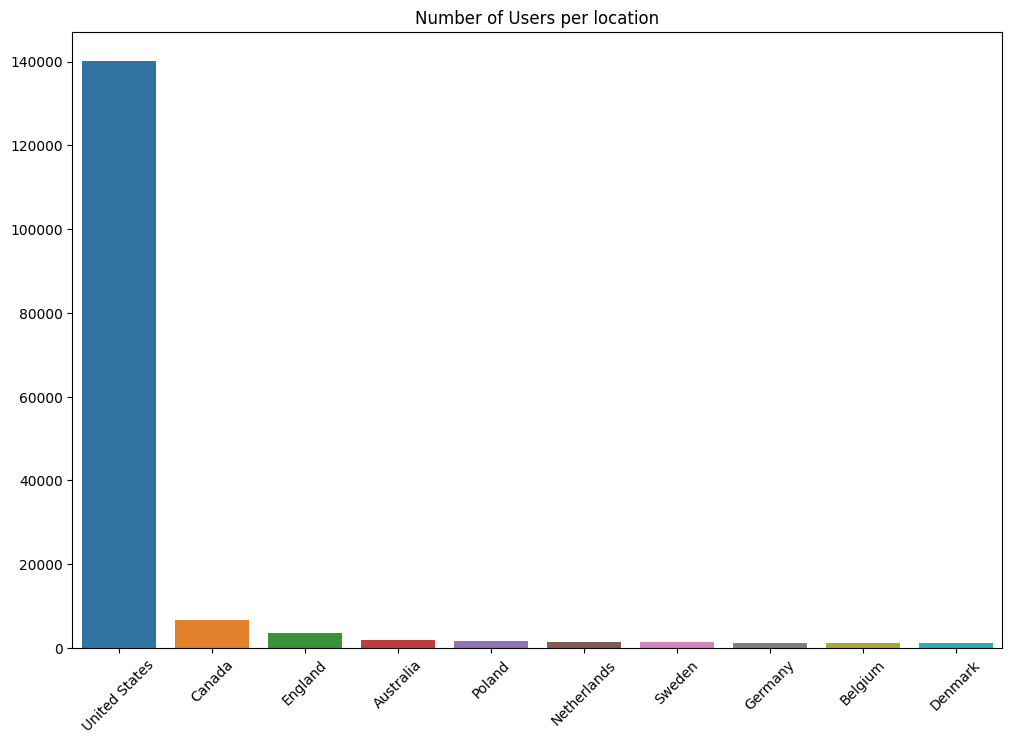

In [22]:
# Plot the distribution of the number of users per country
plt.figure(figsize=(12,8))
sns.barplot(x=users_country['location'].values[:10], y=users_country['total nb of users'].values[:10])
plt.title('Number of Users per location')
plt.xticks(rotation=45)

As we see, the US has much more users than the other countries. This leads us to think that by focusing on this country, we will get the most diverse reviews as they come from many different users. If we would consider Canada for example, we could have bias results as there are not so many users and the reviews come from a small set of people, leading us to provide a perfect beer for very few people. For this reason, our analysis will be focused on the US only.

In [23]:
US_country = 'United States'

# Keep only the rows where the user country is United States
users_ba_df_us = users_ba_df[users_ba_df.location == US_country]
users_rb_df_us = users_rb_df[users_rb_df.location == US_country]

# Keep only the rows where the user country is not from United States
users_ba_df_ca = users_ba_df[users_ba_df.location != US_country]
users_rb_df_ca = users_rb_df[users_rb_df.location != US_country]

In [24]:
# Merge the ratings and users data frames to get the location of the user for each rating
ratings_users_ba_df_us = pd.merge(ratings_ba_df, users_ba_df_us[['user_id', 'location']], on='user_id', how='inner')
ratings_users_rb_df_us = pd.merge(ratings_rb_df, users_rb_df_us[['user_id', 'location']], on='user_id', how='inner')

ratings_users_ba_df_ca = pd.merge(ratings_ba_df, users_ba_df_ca[['user_id', 'location']], on='user_id', how='inner')
ratings_users_rb_df_ca = pd.merge(ratings_rb_df, users_rb_df_ca[['user_id', 'location']], on='user_id', how='inner')

Filtered dataframe to separate ratings from US users from the rest

In [25]:
# filter the ratings dataframes to only keep ratings of the users from the US
ratings_ba_df_us = ratings_users_ba_df_us[ratings_users_ba_df_us.location == US_country]
ratings_ba_df_us.drop('location', axis=1, inplace=True)
ratings_rb_df_us = ratings_users_rb_df_us[ratings_users_rb_df_us.location == US_country]
ratings_rb_df_us.drop('location', axis=1, inplace=True)

# filter the ratings dataframes to only keep ratings of the users not from US
ratings_ba_df_ca = ratings_users_ba_df_ca[ratings_users_ba_df_ca.location != US_country]
ratings_ba_df_ca.drop('location', axis=1, inplace=True)
ratings_rb_df_ca = ratings_users_rb_df_ca[ratings_users_rb_df_ca.location != US_country]
ratings_rb_df_ca.drop('location', axis=1, inplace=True)


Number of ratings from the US in BeerAdvocate: 2346494
Number of ratings from the US in Ratebeer: 3108958
Number of ratings not from US in BeerAdvocate: 369218
Number of ratings not from US in Ratebeer: 4014825


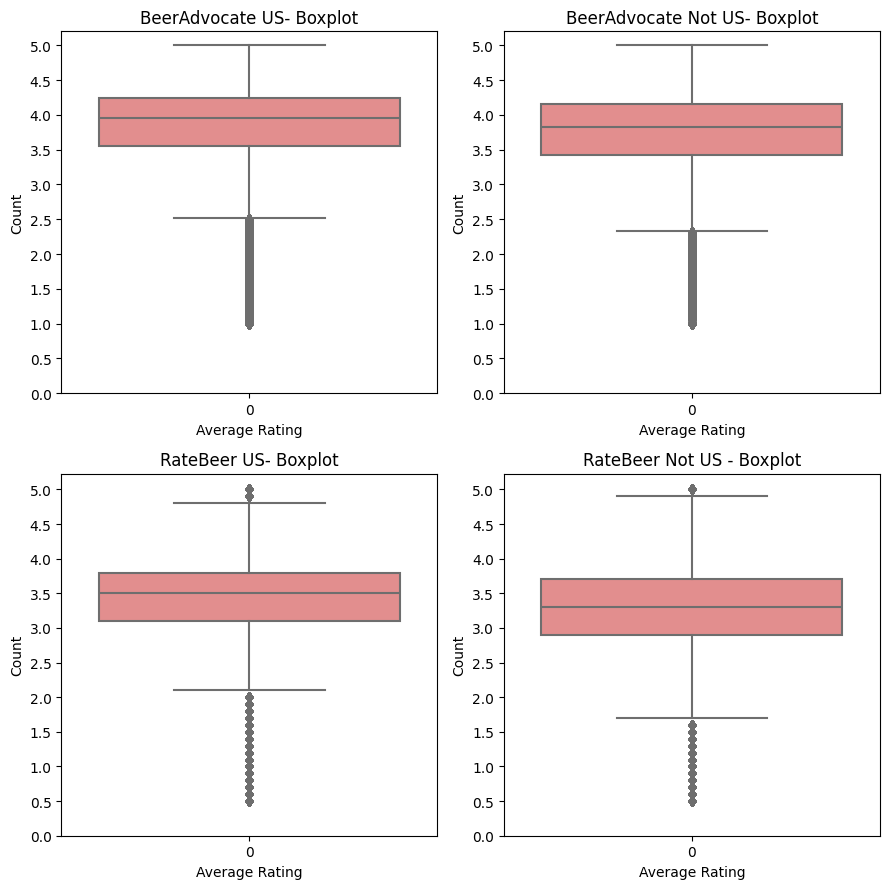

In [26]:
# Plot the distribution of the number of ratings per user
fig, axes = plt.subplots(2, 2, figsize=(9, 9))

# Number of beers in BeerAdvocate and RateBeer
print("Number of ratings from the US in BeerAdvocate:", len(ratings_ba_df_us))
print("Number of ratings from the US in Ratebeer:", len(ratings_rb_df_us))
print("Number of ratings not from US in BeerAdvocate:", len(ratings_ba_df_ca))
print("Number of ratings not from US in Ratebeer:", len(ratings_rb_df_ca))

# BeerAdvocate US- Boxplot
sns.boxplot(ratings_ba_df_us['rating'], ax=axes[0, 0], color='lightcoral')
axes[0, 0].set_xlabel('Average Rating')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_title('BeerAdvocate US- Boxplot')
axes[0, 0].set_yticks(np.arange(0, 5.5, 0.5))

# BeerAdvocate Not US- Boxplot
sns.boxplot(ratings_ba_df_ca['rating'], ax=axes[0, 1], color='lightcoral')
axes[0, 1].set_xlabel('Average Rating')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title('BeerAdvocate Not US- Boxplot')
axes[0, 1].set_yticks(np.arange(0, 5.5, 0.5))

# RateBeer US- Boxplot
sns.boxplot(ratings_rb_df_us['rating'], ax=axes[1, 0], color='lightcoral')
axes[1, 0].set_xlabel('Average Rating')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title('RateBeer US- Boxplot')
axes[1, 0].set_yticks(np.arange(0, 5.5, 0.5))

# RateBeer Not US - Boxplot
sns.boxplot(ratings_rb_df_ca['rating'], ax=axes[1, 1], color='lightcoral')
axes[1, 1].set_xlabel('Average Rating')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('RateBeer Not US - Boxplot')
axes[1, 1].set_yticks(np.arange(0, 5.5, 0.5))

plt.tight_layout()
plt.show()

### Mann-Whithney U Test
* US vs Not US:
    - Null Hypothesis (H0): There is no difference in beer ratings between the US and non-US beers.
    - Alternative Hypothesis (H1): There is a difference in beer ratings between the US and non-US beers.
* US vs US:
    - Null Hypothesis (H0): There is no difference in beer ratings between US beers.
    - Alternative Hypothesis (H1): There is a difference in beer ratings between US beers.
* Not US vs Not US:
    - Null Hypothesis (H0): There is no difference in beer ratings between non-US beers.
    - Alternative Hypothesis (H1): There is a difference in beer ratings between non-US beers.

In [27]:
# test if the ratings from the US and not from the US are from the same distribution
print('BeerAdvocate:')
print('US vs Not US')
print(st.mannwhitneyu(ratings_ba_df_us['rating'], ratings_ba_df_ca['rating']))
print('US vs US')
print(st.mannwhitneyu(ratings_ba_df_us['rating'], ratings_ba_df_us['rating']))
print('Not US vs Not US')
print(st.mannwhitneyu(ratings_ba_df_ca['rating'], ratings_ba_df_ca['rating']))

print('RateBeer:')
print('US vs Not US')
print(st.mannwhitneyu(ratings_rb_df_us['rating'], ratings_rb_df_ca['rating']))
print('US vs US')
print(st.mannwhitneyu(ratings_rb_df_us['rating'], ratings_rb_df_us['rating']))
print('Not US vs Not US')
print(st.mannwhitneyu(ratings_rb_df_ca['rating'], ratings_rb_df_ca['rating']))


BeerAdvocate:
US vs Not US
MannwhitneyuResult(statistic=481028997358.5, pvalue=0.0)
US vs US
MannwhitneyuResult(statistic=2753017046018.0, pvalue=1.0)
Not US vs Not US
MannwhitneyuResult(statistic=68160965762.0, pvalue=1.0)
RateBeer:
US vs Not US
MannwhitneyuResult(statistic=7274970199334.5, pvalue=0.0)
US vs US
MannwhitneyuResult(statistic=4832809922882.0, pvalue=1.0)
Not US vs Not US
MannwhitneyuResult(statistic=8059409890312.5, pvalue=1.0)


From the boxplot, we observe visually small differences in the distribution of the ratings between US users and non-US users. After the Mann-Whitney U Test, we significantly reject the null hypothesis for US vs Not US users, which means that the distributions are significantly different. Thus, we can focus uniquely on US users to avoid any bias in our analysis. 

Filter the datasets to only keep users from the US:

In [28]:
ratings_ba_df = ratings_ba_df_us
ratings_rb_df = ratings_rb_df_us

In [29]:
nbr_ratings_ba = ratings_ba_df.shape[0]
nbr_ratings_rb = ratings_rb_df.shape[0]

print('Number of ratings in BeerAdvocate: {}'.format(nbr_ratings_ba))
print('Number of ratings in RateBeer: {}'.format(nbr_ratings_rb))

Number of ratings in BeerAdvocate: 2346494
Number of ratings in RateBeer: 3108958


## Are there users who excessively rate a beer in a short time period ?

Motivation: we want to handle the cases where we could have many ratings from a specific user for the same beer as it could be a user that is trying to bias the rating of a particular beer

In [30]:
# Assuming ratings_combined_df is your DataFrame
threshold = 3  # Adjust this threshold based on your criteria

# Group by user_id, beer_id, and year_month, and count the number of ratings
user_beer_counts_ba = ratings_ba_df.groupby(['user_id', 'beer_id', 'year_month']).size().reset_index(name='rating_count')
user_beer_counts_rb = ratings_rb_df.groupby(['user_id', 'beer_id', 'year_month']).size().reset_index(name='rating_count')

# Filter for instances where the rating count exceeds the threshold
excessive_ratings_ba = user_beer_counts_ba[user_beer_counts_ba['rating_count'] > threshold]
excessive_ratings_rb = user_beer_counts_rb[user_beer_counts_rb['rating_count'] > threshold]

print("Excessive ratings for BeerAdvocate:")
print(excessive_ratings_ba)
print("Excessive ratings for RateBeer:")
print(excessive_ratings_rb)

Excessive ratings for BeerAdvocate:
Empty DataFrame
Columns: [user_id, beer_id, year_month, rating_count]
Index: []
Excessive ratings for RateBeer:
         user_id  beer_id year_month  rating_count
184060      3070      252 2002-11-01             5
184061      3070      403 2002-01-01             5
184062      3070      411 2002-01-01             5
184063      3070      474 2002-01-01             5
184064      3070      707 2002-01-01             5
1474422    46797       46 2007-01-01            41
1474423    46797       86 2007-03-01            41
1474424    46797       87 2007-01-01            41
1474425    46797      145 2007-01-01            41
1474426    46797      589 2007-02-01            41
1474427    46797      594 2007-02-01            41
1474428    46797      662 2007-03-01            41
1474429    46797      663 2007-03-01            41
1474430    46797      690 2007-01-01            41
1474431    46797      714 2007-01-01            41
1474432    46797      745 2007-02-01

We decided to set the threshold to 3 as rating a same beer more than 3 times per month can seem suspicious. We have identified two users in RateBeer who rated the same beer excessively within a specific month. For example, user 46797 has rated 41 times many beers each month from december 2006 to march 2007.  
Such behavior is suspicious, and as a precautionary measure, we've decided to remove these users from the dataset to keep the reliability of the ratings.

In [31]:
# Remove the suspicious users
users_to_remove = [46797, 3070]
ratings_combined_df = ratings_ba_df[~ratings_ba_df['user_id'].isin(users_to_remove)]


## What is a popular beer ?

**Popularity definition:** By popular we mean with respect to the number of **good** reviews


#### Distribution of the average rating in BeerAdvocate

In [32]:
ratings_ba_df[['appearance', 'aroma', 'palate', 'style', 'taste', 'overall', 'rating']].describe()

appearance         aroma        palate         taste       overall  \
count  2.310684e+06  2.310684e+06  2.310684e+06  2.310684e+06  2.310684e+06   
mean   3.900441e+00  3.811440e+00  3.817201e+00  3.854748e+00  3.862540e+00   
std    5.870042e-01  6.626348e-01  6.496978e-01  6.964354e-01  6.714755e-01   
min    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
25%    3.500000e+00  3.500000e+00  3.500000e+00  3.500000e+00  3.500000e+00   
50%    4.000000e+00  4.000000e+00  4.000000e+00  4.000000e+00  4.000000e+00   
75%    4.250000e+00  4.250000e+00  4.250000e+00  4.500000e+00  4.250000e+00   
max    5.000000e+00  5.000000e+00  5.000000e+00  5.000000e+00  5.000000e+00   

             rating  
count  2.346494e+06  
mean   3.846907e+00  
std    6.044712e-01  
min    1.000000e+00  
25%    3.550000e+00  
50%    3.950000e+00  
75%    4.240000e+00  
max    5.000000e+00

#### Distribution of the average rating in RateBeer

In [33]:
ratings_rb_df[['appearance', 'aroma', 'palate', 'style', 'taste', 'overall', 'rating']].describe()

appearance         aroma        palate         taste       overall  \
count  3.108958e+06  3.108958e+06  3.108958e+06  3.108958e+06  3.108958e+06   
mean   3.536766e+00  6.581593e+00  3.381866e+00  6.651427e+00  1.364188e+01   
std    7.864937e-01  1.540261e+00  8.069702e-01  1.529019e+00  3.127803e+00   
min    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
25%    3.000000e+00  6.000000e+00  3.000000e+00  6.000000e+00  1.200000e+01   
50%    4.000000e+00  7.000000e+00  3.000000e+00  7.000000e+00  1.400000e+01   
75%    4.000000e+00  8.000000e+00  4.000000e+00  8.000000e+00  1.600000e+01   
max    5.000000e+00  1.000000e+01  5.000000e+00  1.000000e+01  2.000000e+01   

             rating  
count  3.108958e+06  
mean   3.379354e+00  
std    6.799184e-01  
min    5.000000e-01  
25%    3.100000e+00  
50%    3.500000e+00  
75%    3.800000e+00  
max    5.000000e+00

Number of beers in BeerAdvocate: 2346494
Number of beers in RateBeer: 3108958


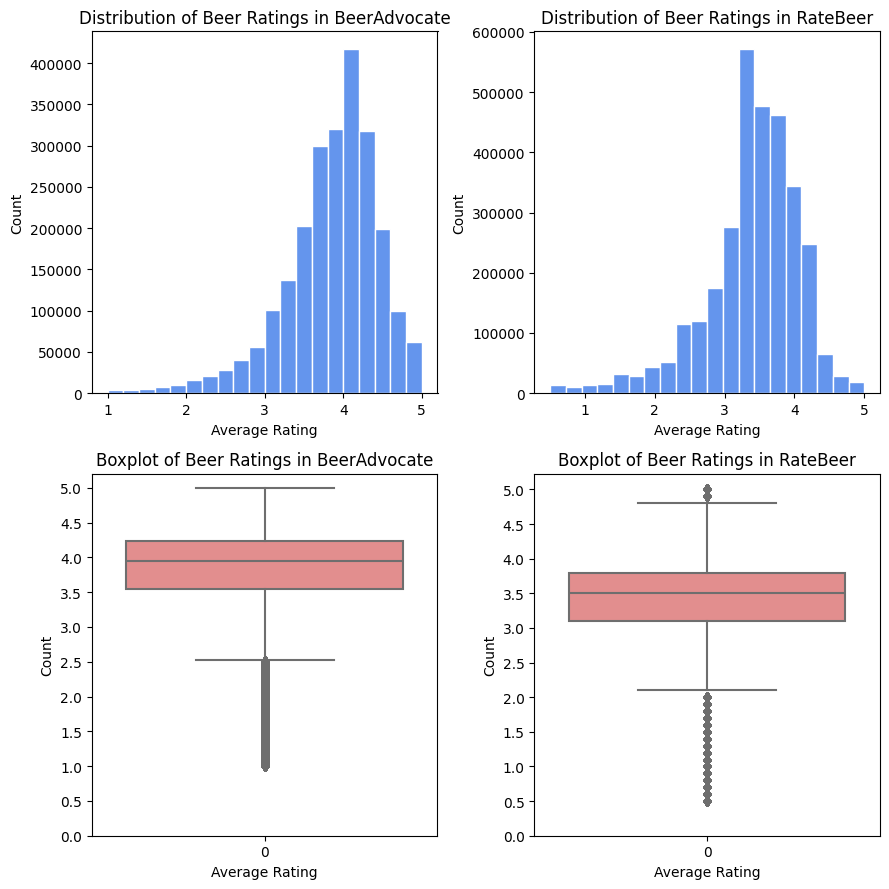

In [34]:
fig, axes = plt.subplots(2, 2, figsize=(9, 9))

# Number of beers in BeerAdvocate and RateBeer
print("Number of beers in BeerAdvocate:", len(ratings_ba_df))
print("Number of beers in RateBeer:", len(ratings_rb_df))

# BeerAdvocate - Histogram
axes[0, 0].hist(ratings_ba_df['rating'], bins=20, color='cornflowerblue', edgecolor='white')
axes[0, 0].set_xlabel('Average Rating')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_title('Distribution of Beer Ratings in BeerAdvocate')

# RateBeer - Histogram
axes[0, 1].hist(ratings_rb_df['rating'], bins=20, color='cornflowerblue', edgecolor='white')
axes[0, 1].set_xlabel('Average Rating')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title('Distribution of Beer Ratings in RateBeer')
axes[0, 1].ticklabel_format(style="plain", axis="y")

# BeerAdvocate - Boxplot
sns.boxplot(ratings_ba_df['rating'], ax=axes[1, 0], color='lightcoral')
axes[1, 0].set_xlabel('Average Rating')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title('Boxplot of Beer Ratings in BeerAdvocate')
axes[1, 0].set_yticks(np.arange(0, 5.5, 0.5))

# RateBeer - Boxplot
sns.boxplot(ratings_rb_df['rating'], ax=axes[1, 1], color='lightcoral')
axes[1, 1].set_xlabel('Average Rating')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('Boxplot of Beer Ratings in RateBeer')
axes[1, 1].set_yticks(np.arange(0, 5.5, 0.5))

plt.tight_layout()
plt.show()

In [35]:
mean_ba = ratings_ba_df.rating.mean()
mean_rb = ratings_rb_df.rating.mean()

print("Mean rating in BeerAdvocate:", mean_ba)
print("Mean rating in RateBeer:", mean_rb)

Mean rating in BeerAdvocate: 3.846906563579535
Mean rating in RateBeer: 3.3793541115704993


### T-test on the ratings of the two datasets

Let's quantify the observed results with a t-test. 

In [36]:
t_statistic, p_value = st.ttest_ind(ratings_ba_df['rating'], ratings_rb_df['rating'])

# Output the results
print("T-Statistic:", t_statistic)
print("P-Value:", p_value)

if p_value < 0.05:
    print("The ratings in the two datasets are statistically different.")
else:
    print("There is no significant difference in the ratings between the two datasets.")


T-Statistic: 833.6675344272143
P-Value: 0.0
The ratings in the two datasets are statistically different.


As observed from the tables and the plot above, even though the distributions have a similar shape, i.e. normal distribution, they have a different average mean ratings. Indeed, users from the RateBeer dataset seem to be harsher in their ratings.

Now, as defined above, our popularity definition concerns the number of good ratings. A question that arises is: what can be considered as a good rating?

The ratings are continuous numbers between 0 to 5. One idea is to keep the ratings above the average mean of the two datasets and consider them as good rating. With this, we take in account the different distribution of the ratings into the two datasets and find a relatively good threshold.

Let's see what are the 10 most rated beer styles in each dataset:

Number of Beer Styles in AdvocateBeer: 104
Number of Beer Styles in RateBeer: 90


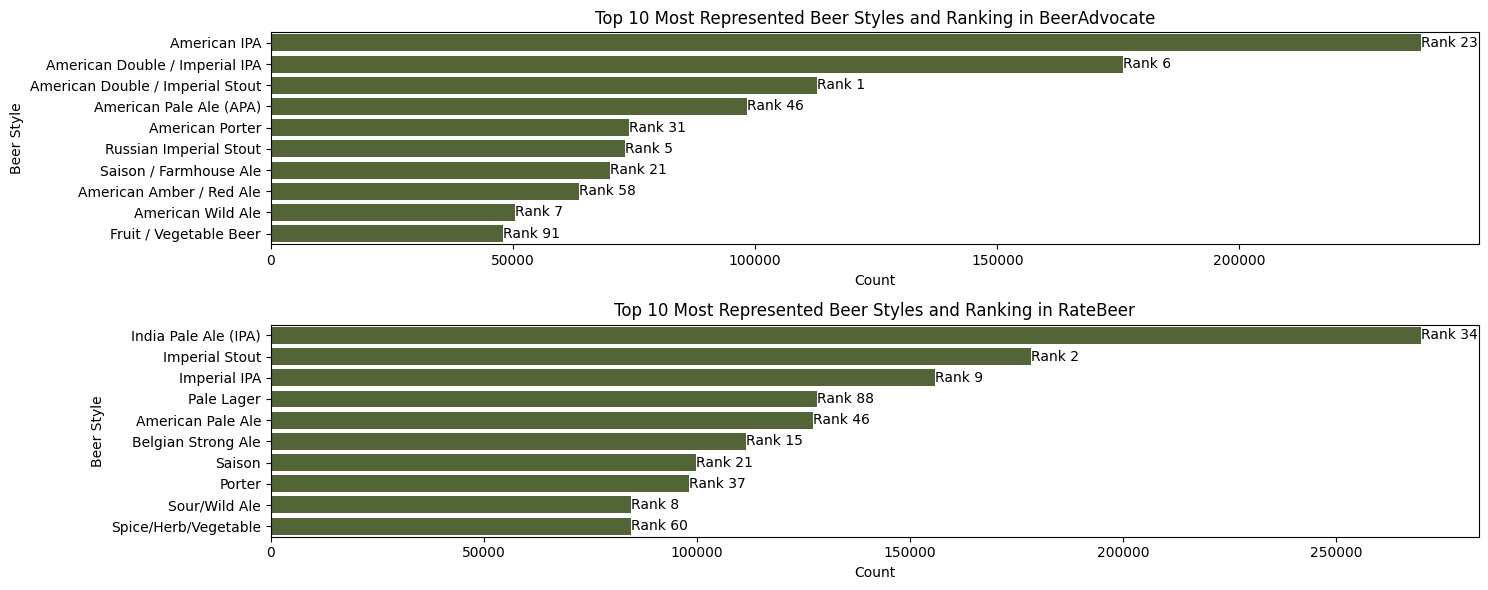

In [37]:
top_ratings_by_style_ba = ratings_ba_df.groupby('style')['rating'].mean().sort_values(ascending=False)
top_ratings_by_style_rb = ratings_rb_df.groupby('style')['rating'].mean().sort_values(ascending=False)

print(f"Number of Beer Styles in AdvocateBeer: {len(top_ratings_by_style_ba)}")
print(f"Number of Beer Styles in RateBeer: {len(top_ratings_by_style_rb)}")

# Number of top beer styles to plot
x = 10

# Create a figure with two subplots
fig, axes = plt.subplots(2, 1, figsize=(15, 6))

# BeerAdvocate
plot1 = sns.countplot(y='style', data=ratings_ba_df, order=ratings_ba_df['style'].value_counts().index[:x], color='darkolivegreen', ax=axes[0])
for i, style in enumerate(ratings_ba_df['style'].value_counts().index[:x]):
    ranking = top_ratings_by_style_ba.index.get_loc(style) + 1  
    plot1.text(ratings_ba_df['style'].value_counts()[i], i, f'Rank {ranking}', va='center')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Beer Style')
axes[0].set_title(f'Top {x} Most Represented Beer Styles and Ranking in BeerAdvocate')

# RateBeer
plot2 = sns.countplot(y='style', data=ratings_rb_df, order=ratings_rb_df['style'].value_counts().index[:x], color='darkolivegreen', ax=axes[1])
for i, style in enumerate(ratings_rb_df['style'].value_counts().index[:x]):
    ranking = top_ratings_by_style_rb.index.get_loc(style) + 1  
    plot2.text(ratings_rb_df['style'].value_counts()[i], i, f'Rank {ranking}', va='center')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Beer Style')
axes[1].set_title(f'Top {x} Most Represented Beer Styles and Ranking in RateBeer')

plt.tight_layout()
plt.show()

From the two plots above we can observe that a beer style can be popular but not have the best rating. For example in the plot of the RateBeer dataset, we see that the 3rd most popular beer style with respect to “count” is the 91th most popular beer style (over 93) when it comes to mean average rating.

## Final datasets to continue further analysis

To facilitate further analysis, we prepare a dataframe with the useful informations such as the location of the brewery and the volume of alcohol of the beer.

In [38]:
# verify if there are any duplicates in the beers dataset with the new_id column
print('Number of duplicates in BeerAdvocate:', beers_ba_df.duplicated(subset=['new_id']).sum())
print('Number of duplicates in RateBeer:', beers_rb_df.duplicated(subset=['new_id']).sum())

duplicate_beers_ba = beers_ba_df[beers_ba_df.duplicated(subset=['new_id'], keep=False)]
duplicate_beers_rb = beers_rb_df[beers_rb_df.duplicated(subset=['new_id'], keep=False)]


first_duplicate_beer_ba = duplicate_beers_ba.iloc[0]
first_duplicate_beer_rb = duplicate_beers_rb.iloc[0]

# display the row with the beer_id in the BeerAdvocate dataset and the RateBeer dataset
print('BeerAdvocate:')
display(beers_ba_df[beers_ba_df.new_id == first_duplicate_beer_ba.new_id])

print('RateBeer:')
display(beers_rb_df[beers_rb_df.new_id == first_duplicate_beer_rb.new_id])

Number of duplicates in BeerAdvocate: 483
Number of duplicates in RateBeer: 120
BeerAdvocate:


beer_id  beer_name  brewery_id          brewery_name  \
6105   139099  Amber Ale       33363  Fourpure Brewing Co.   
6123   165403  Amber Ale       37085  Fourpure Brewing Co.   

                         style  nbr_ratings  nbr_reviews   avg  ba_score  \
6105  American Amber / Red Ale            5            1  3.54       NaN   
6123  American Amber / Red Ale            1            0  3.12       NaN   

      bros_score  abv  avg_computed  zscore  nbr_matched_valid_ratings  \
6105         NaN  5.1          3.53     NaN                          0   
6123         NaN  5.1          3.12     NaN                          0   

      avg_matched_valid_ratings  \
6105                        NaN   
6123                        NaN   

                                                 new_id  
6105  d7c796bb27a3640cc09c61733e98c7d18ebdd978add017...  
6123  d7c796bb27a3640cc09c61733e98c7d18ebdd978add017...

RateBeer:


beer_id         beer_name  brewery_id brewery_name   style  nbr_ratings  \
3159   353940  Talón de Aquiles       24064    cerartmex  Porter            0   
3160   353941  Talón de Aquiles       24064    cerartmex  Porter            0   

      overall_score  style_score  avg  abv  avg_computed  zscore  \
3159            NaN          NaN  NaN  5.0           NaN     NaN   
3160            NaN          NaN  NaN  5.0           NaN     NaN   

      nbr_matched_valid_ratings  avg_matched_valid_ratings  \
3159                          0                        NaN   
3160                          0                        NaN   

                                                 new_id  
3159  4500744f834c05d1faf681aff0e097b6cf2c7b7d8c3fad...  
3160  4500744f834c05d1faf681aff0e097b6cf2c7b7d8c3fad...

In [39]:
# verify if there are any duplicates in the breweries dataset with the new_id column
print('Number of duplicates in BeerAdvocate:', breweries_ba_df.duplicated(subset=['new_id']).sum())
print('Number of duplicates in RateBeer:', breweries_rb_df.duplicated(subset=['new_id']).sum())

duplicate_breweries_ba = breweries_ba_df[breweries_ba_df.duplicated(subset=['new_id'], keep=False)]
duplicate_breweries_rb = breweries_rb_df[breweries_rb_df.duplicated(subset=['new_id'], keep=False)]


first_duplicate_brewery_ba = duplicate_breweries_ba.iloc[0]
first_duplicate_brewery_rb = duplicate_breweries_rb.iloc[0]

# display the row with the brewery_id in the BeerAdvocate dataset and the RateBeer dataset
print('BeerAdvocate:')
display(breweries_ba_df[breweries_ba_df.new_id == first_duplicate_brewery_ba.new_id])

print('RateBeer:')
display(breweries_rb_df[breweries_rb_df.new_id == first_duplicate_brewery_rb.new_id])

Number of duplicates in BeerAdvocate: 315
Number of duplicates in RateBeer: 4
BeerAdvocate:


id location             name  nbr_beers  \
68  34598    Wales  Rhymney Brewery          2   
69  12936    Wales  Rhymney Brewery         13   

                                               new_id  
68  c6df0aa690b33dca927f0cb52d0de9435a44337d8531ac...  
69  c6df0aa690b33dca927f0cb52d0de9435a44337d8531ac...

RateBeer:


id location                   name  nbr_beers  \
1437  23620   Canada  Ridge Brewing Company         15   
1491   3317   Canada  Ridge Brewing Company         12   

                                                 new_id  
1437  d1654b815d4c4fe51e802b37bd71993613aef646d6df63...  
1491  d1654b815d4c4fe51e802b37bd71993613aef646d6df63...

We observe that the same beer appears multiple times in the dataset of beers description and breweries description in BeerAdvocate and RateBeer. Let's drop those duplicates. 

In [40]:
# drop the duplicates
beers_ba_df.drop_duplicates(subset=['new_id'], inplace=True)
beers_rb_df.drop_duplicates(subset=['new_id'], inplace=True)

breweries_ba_df.drop_duplicates(subset=['new_id'], inplace=True)
breweries_rb_df.drop_duplicates(subset=['new_id'], inplace=True)

In [41]:
# add column abv to the ratings datasets
ratings_ba_df['abv'] = ratings_ba_df['new_id_beer'].map(beers_ba_df.set_index('new_id')['abv'])
ratings_rb_df['abv'] = ratings_rb_df['new_id_beer'].map(beers_rb_df.set_index('new_id')['abv'])

# add column brewery_location to the ratings datasets
ratings_ba_df['brewery_location'] = ratings_ba_df['new_id_brewery'].map(breweries_ba_df.set_index('new_id')['location'])
ratings_rb_df['brewery_location'] = ratings_rb_df['new_id_brewery'].map(breweries_rb_df.set_index('new_id')['location'])

# Add column 'dataset' to the datasets to know where each row comes from orignally 
ratings_ba_df['dataset'] = 'BeerAdvocate'
ratings_rb_df['dataset'] = 'RateBeer'

# merge the two ratings dataframes
ratings_combined_df_untouched = pd.concat([ratings_ba_df_untouched, ratings_rb_df_untouched], ignore_index=True)
ratings_combined_df = pd.concat([ratings_ba_df, ratings_rb_df], ignore_index=True)

# Temporal Analysis

## General Analysis

In [42]:
def dataframe_time_analysis(df, year_lower, year_upper):
    # create a year_month column
    ratings_combined_df['year_month'] = df['year'].astype(str) + '-' + df['month'].astype(str)

    # convert the year_month column to datetime format
    ratings_combined_df['year_month'] = pd.to_datetime(ratings_combined_df['year_month'])

    # group by year_month and count the number of ratings per year_month
    year_month_ratings_count = ratings_combined_df.groupby('year_month')['year_month'].count()
    
    # creating a new dataframe with the number of ratings per year_month
    year_month_ratings_count_df = pd.DataFrame({'year_month': year_month_ratings_count.index, 'nbr_ratings': year_month_ratings_count.values})

    # create column year and month
    year_month_ratings_count_df['year'] = year_month_ratings_count_df['year_month'].dt.year
    year_month_ratings_count_df['month'] = year_month_ratings_count_df['year_month'].dt.month

    # keep only rows where the year is greater than 2011 and less than 2017 
    year_month_ratings_count_filtered = year_month_ratings_count_df[(year_month_ratings_count_df.year >= year_lower) & (year_month_ratings_count_df.year < year_upper)]

    # compute the mean number of ratings per month
    mean_ratings_per_month = year_month_ratings_count_filtered.groupby('month')['nbr_ratings'].mean().reset_index(name='mean_nbr_ratings')

    return year_month_ratings_count, year_month_ratings_count_filtered, mean_ratings_per_month 

In [43]:
year_month_ratings_count, year_month_ratings_count_filtered, mean_ratings_per_month = dataframe_time_analysis(ratings_combined_df, 2008, 2017)

# plot with plotly the mean number of ratings per month
fig = px.line(year_month_ratings_count_filtered, x='month', y='nbr_ratings', color='year', title='Mean Number of Ratings per Month (from 2008 to 2016)')
fig.add_trace(go.Scatter(x=year_month_ratings_count_filtered.month, y=mean_ratings_per_month.mean_nbr_ratings, mode='lines', name='Mean Number of Ratings', line=dict(color='black', dash='dash', width=4)))

fig.show()

![](plots/monthRatings.png)

From the plot above, we observe some seasonality of the beer's ratings. Indeed, we can remark that some months have some peak of ratings. The months December/January have the biggest increase. We can also see that the months of March, August and also slightly less May and October, have increases of the number of ratings. 

Let's observe the count of good ratings now. As precised above, a rating is considered as good when it is over the average mean of the dataset. 

From the plot above, we observe some seasonality of the beer's ratings. Indeed, we can remark that some months have some peak of ratings. The months December/January have the biggest increase. We can also see that the months of March, August and also slightly less May and October, have increases of the number of ratings.

Let's observe the count of good ratings now. As precised above, a rating is considered as good when it is over the average mean of the dataset. 

In [44]:
average_ratings_ba_df = ratings_ba_df.rating.mean()
average_ratings_rb_df = ratings_rb_df.rating.mean()

print('Average rating for BeerAdvocate:', average_ratings_ba_df)
print('Average rating for RateBeer:', average_ratings_rb_df)

Average rating for BeerAdvocate: 3.846906563579535
Average rating for RateBeer: 3.3793541115704993


In [45]:
good_ratings_ba_df = ratings_ba_df[ratings_ba_df.rating >= average_ratings_ba_df]
good_ratings_rb_df = ratings_rb_df[ratings_rb_df.rating >= average_ratings_rb_df]

print('Number of good ratings for BeerAdvocate:', good_ratings_ba_df.shape[0])
print('Number of good ratings for RateBeer:', good_ratings_rb_df.shape[0])

Number of good ratings for BeerAdvocate: 1358021
Number of good ratings for RateBeer: 1863770


In [46]:
good_ratings_df = pd.concat([good_ratings_ba_df, good_ratings_rb_df], ignore_index=True)

year_month_good_ratings_count, year_month_good_ratings_count_filtered, mean_good_ratings_per_month = dataframe_time_analysis(good_ratings_df, 2008, 2017)

# plot with plotly the mean number of ratings per month
fig = px.line(year_month_good_ratings_count_filtered, x='month', y='nbr_ratings', color='year', title='Mean Number of Good Ratings per Month (from 2008 to 2016)')
fig.add_trace(go.Scatter(x=year_month_good_ratings_count_filtered.month, y=mean_good_ratings_per_month.mean_nbr_ratings, mode='lines', name='Mean Number of Good Ratings', line=dict(color='black', dash='dash', width=4)))

fig.show()

![](plots/mean_good_ratings_monthly.png)

We have proved that there are some seasonality in the beer's number of ratings, and even more specifically, in the number of good ratings.

Let's quantify it by a statistical test. 

In [47]:
ratings_ba_df_copy = ratings_ba_df.copy()
ratings_rb_df_copy = ratings_rb_df.copy()

In [48]:
# add a new column "is_good" to the ratings data frame to indicate if the rating is good or not
ratings_ba_df_copy['is_good'] = ratings_ba_df_copy['rating'] >= average_ratings_ba_df
ratings_rb_df_copy['is_good'] = ratings_rb_df_copy['rating'] >= average_ratings_rb_df

ratings_ba_df_copy['is_bad'] = ratings_ba_df_copy['rating'] < average_ratings_ba_df
ratings_rb_df_copy['is_bad'] = ratings_rb_df_copy['rating'] < average_ratings_rb_df

# concatenate the two data frames
ratings_combined_df_copy = pd.concat([ratings_ba_df_copy, ratings_rb_df_copy], ignore_index=True)

# conveert to int 
ratings_combined_df_copy['is_good'] = ratings_combined_df_copy['is_good'].astype(int)
ratings_combined_df_copy['is_bad'] = ratings_combined_df_copy['is_bad'].astype(int)

In [49]:
# group by beer_id and then by year and count the number of good and bad ratings
beer_good_bad_ratings_monthly = ratings_combined_df_copy.groupby(['new_id_beer', 'month'])[['is_good', 'is_bad']].sum().reset_index()
beer_good_bad_ratings_monthly['total_nbr_ratings'] = beer_good_bad_ratings_monthly['is_good'] + beer_good_bad_ratings_monthly['is_bad']

In [50]:
# group by beer_id and then by year and count the number of good and bad ratings
beer_good_bad_ratings_yearly = ratings_combined_df_copy.groupby(['new_id_beer', 'year'])[['is_good', 'is_bad']].sum().reset_index()
beer_good_bad_ratings_yearly['total_nbr_ratings'] = beer_good_bad_ratings_yearly['is_good'] + beer_good_bad_ratings_yearly['is_bad']

In [51]:
# change name of columns 
beer_good_bad_ratings_monthly.rename(columns={'is_good': 'nbr_good_ratings', 'is_bad': 'nbr_bad_ratings'}, inplace=True)
beer_good_bad_ratings_yearly.rename(columns={'is_good': 'nbr_good_ratings', 'is_bad': 'nbr_bad_ratings'}, inplace=True)

We do a ANOVA test to see if there is any significant difference in the means of the number of good ratings across months. 

In [52]:
grouped_data = [group['nbr_good_ratings'] for _, group in beer_good_bad_ratings_monthly.groupby('month')]
result_anova, p_anova = f_oneway(*grouped_data)

print('p-value for ANOVA test:', p_anova)
print('F-statistic for ANOVA test:', result_anova)

p-value for ANOVA test: 8.421747857216745e-56
F-statistic for ANOVA test: 26.419871895827423


**Interpetation:**

* Assuming here that : 
    * Null Hypothesis: There is no significant difference in the means of the number of good ratings across months.
    * Alternative Hypothesis (H1): There is a significant difference in the means of the number of good ratings across at least two months.

* Given the very small p-value, you would reject the null hypothesis. Therefore, you have statistical evidence to conclude that there are significant differences in the means of the number of good ratings across different months. The F-statistic indicates the strength of this evidence, with a larger F-statistic supporting the rejection of the null hypothesis.

Let's observe now if there is any statistical difference between the average rating over the months 

In [53]:
# group by beer_id and then by year and count the number of good and bad ratings
beer_ratings_monthly = ratings_combined_df_copy.groupby(['new_id_beer', 'month'])['rating'].mean().reset_index()
beer_ratings_monthly.rename(columns={'rating': 'average_rating'}, inplace=True)

In [54]:
grouped_average = [group['average_rating'] for _, group in beer_ratings_monthly.groupby('month')]
result_anova, p_anova = f_oneway(*grouped_average)

print('p-value for ANOVA test:', p_anova)
print('F-statistic for ANOVA test:', result_anova)

p-value for ANOVA test: 2.6455334969582316e-145
F-statistic for ANOVA test: 64.63517229474856


**Interpetation:**

* Assuming here that : 
    * Null Hypothesis: There is no significant difference in the average ratings across months.
    * Alternative Hypothesis (H1): There is a significant difference in the average ratings across at least two months.

* Given the very small p-value, you would reject the null hypothesis. Therefore, you have statistical evidence to conclude that there are significant differences in the average ratings across different months. The F-statistic indicates the strength of this evidence, with a larger F-statistic supporting the rejection of the null hypothesis.

**Conclusion:** 
* We observe statistical significance of the number of good ratings across months. 
* We observe statistical significance of the average ratings across months. 
* Thus, we quantify the existence of seasonality of the popularity of beers. 

### Some examples

Let's now observe the average ratings per month of some Beer's style. Can we see any particular differences? Have those styles any period where the number of ratings increases?

In [55]:
sample_styles = ['Oktoberfest/Märzen', 'American Pale Ale', 'Belgian Strong Dark Ale']

for style in sample_styles: 
    ratings_users_sample = ratings_combined_df[ratings_combined_df['style'] == style]

    year_month_ratings_count, year_month_ratings_count_filtered, mean_ratings_per_month = dataframe_time_analysis(ratings_users_sample, 2008, 2017)
    
    # Plot with plotly the mean number of ratings per month
    fig = px.line(year_month_ratings_count_filtered, x='month', y='nbr_ratings', color='year', title='Mean Number of Ratings per Month for {}'.format(style))
    fig.add_trace(go.Scatter(x=year_month_ratings_count_filtered.month, y=mean_ratings_per_month.mean_nbr_ratings, mode='lines', name='Mean Number of Ratings', line=dict(color='black', dash='dash', width=4)))

    fig.show()

![](plots/monthlyOktober.png)
![](plots/monthlyAPA.png)
![](plots/monthBelgian.png)

From the three plots, we observe big differences of the average ratings over a year. The 'Oktoberfest/Märzen' style of beers has a big increases of the ratings during the Oktoberfest period, in October. During the rest of the year, the number of ratings is low and does not fluctuates at all.

One of the most rated style is the APA, and as observed in the plot, the number of ratings does not have huge increases at some period. The style is quite popular throughout the year.

Finally the Belgian Strong Dark has a hight number of ratings around the end of the year, as observed from the mean number of ratings line.

# On the road to the perfect beer ! 

## Preferred location 

As first step towards our journey, we want to see if the provenance of the beer has any impact on the beers ratings. Do consumers have any preference towards a certain location ? If yes, which one ? 

In [240]:
ratings_combinedLOCATION_df = ratings_combined_df.copy()

# compute the average rating for each dataframe
avg_BA = ratings_combinedLOCATION_df[ratings_combinedLOCATION_df['dataset'] == 'BeerAdvocate']['rating'].mean()
avg_RB = ratings_combinedLOCATION_df[ratings_combinedLOCATION_df['dataset'] == 'RateBeer']['rating'].mean()

# compare the rating to average_rating for the respective subset
ratings_combinedLOCATION_df['good_review'] = False
ratings_combinedLOCATION_df.loc[ratings_combinedLOCATION_df['dataset'] == 'BeerAdvocate', 'good_review'] = ratings_combinedLOCATION_df['rating'] > avg_BA
ratings_combinedLOCATION_df.loc[ratings_combinedLOCATION_df['dataset'] == 'RateBeer', 'good_review'] = ratings_combinedLOCATION_df['rating'] > avg_RB

In [241]:
# do the same as below but for ratings_combinedLOCATION_df
min_r_BA = ratings_combinedLOCATION_df[ratings_combinedLOCATION_df['dataset'] == 'BeerAdvocate']['rating'].min()
max_r_BA = ratings_combinedLOCATION_df[ratings_combinedLOCATION_df['dataset'] == 'BeerAdvocate']['rating'].max()
min_r_RB = ratings_combinedLOCATION_df[ratings_combinedLOCATION_df['dataset'] == 'RateBeer']['rating'].min()
max_r_RB = ratings_combinedLOCATION_df[ratings_combinedLOCATION_df['dataset'] == 'RateBeer']['rating'].max()
print('Minimum rating for BeerAdvocate:', min_r_BA)
print('Minimum rating for RateBeer:', min_r_RB)
print('Maximum rating for BeerAdvocate:', max_r_BA)
print('Maximum rating for RateBeer:', max_r_RB)

Minimum rating for BeerAdvocate: 1.0
Minimum rating for RateBeer: 0.5
Maximum rating for BeerAdvocate: 5.0
Maximum rating for RateBeer: 5.0


As the worst rating that can possible be given for the two datasets, it is necessary to put the ratings on the same scale. We decide to scale all ratings to [0, 1].

In [242]:
ratings_combinedLOCATION_df.loc[ratings_combinedLOCATION_df['dataset'] == 'BeerAdvocate', 'rating'] = (ratings_combinedLOCATION_df['rating'] - min_r_BA) / (max_r_BA - min_r_BA)
ratings_combinedLOCATION_df.loc[ratings_combinedLOCATION_df['dataset'] == 'RateBeer', 'rating'] = (ratings_combinedLOCATION_df['rating'] - min_r_RB) / (max_r_RB - min_r_RB)

1. Group, merge, rank ratings: product, month, year

Group according to new_beer_id, month and year

In [243]:
ratings_groupBeerIDMonthYear_df = ratings_combinedLOCATION_df.copy()

# group the ratings by new_id_beer & month and take average of rating and sum of above_average
ratings_groupBeerIDMonthYear_df = ratings_groupBeerIDMonthYear_df.groupby(['new_id_beer', 'month', 'year']).agg({'beer_name': 'first', 'beer_id': 'first', 'brewery_id': 'first', 'brewery_name': 'first', 'style': 'first', 'rating': ['mean', 'count'], 'good_review': 'sum', 'brewery_location': 'first', 'dataset': 'first'}).reset_index()
ratings_groupBeerIDMonthYear_df.columns = ['new_id_beer', 'month', 'year', 'beer_name', 'beer_id', 'brewery_id', 'brewery_name', 'style', 'average_rating', 'total_ratings', 'good_review_count', 'brewery_location', 'dataset']

2. Merge the two datasets: beer_name (product), month and year

To correctly get the average_rating, need to:
- weigh average_rating, as weight total_ratings is used
- take the sum of weighted average_ratings for the same beer
- divide by the sum of weights
  
The aggregate function takes the sum of the weights and the sum of the weighted average_ratings --> only need to divide by the weight, which at this point is the sum of weights.


In [244]:
ratings_mergeBeerMonthYear_df = ratings_groupBeerIDMonthYear_df.copy()

# weigh average_rating
ratings_mergeBeerMonthYear_df['average_rating'] = ratings_mergeBeerMonthYear_df['average_rating'] * ratings_mergeBeerMonthYear_df['total_ratings']

# group by beer_name and specify how to aggregate the columns (coluns beer_id, dataset and brewery_id are dropped automatically)
ratings_mergeBeerMonthYear_df = ratings_mergeBeerMonthYear_df.groupby(['beer_name', 'month', 'year']).agg({'brewery_name': 'first', 'brewery_location': 'first', 'style': 'first', 'average_rating': 'sum', 'total_ratings': 'sum', 'good_review_count': 'sum', 'new_id_beer': 'first'}).reset_index()

# divide the sum of average_rating by the sum of weight
ratings_mergeBeerMonthYear_df['average_rating'] = ratings_mergeBeerMonthYear_df['average_rating'] / ratings_mergeBeerMonthYear_df['total_ratings']


3. Rank dataframes

For the dataframe that contains the ratings for distinct beers, months and years we rank according to year, month, highest average_rating and good_review_count

In [245]:
ratings_rankBeerMonthYear_df = ratings_mergeBeerMonthYear_df.copy()

# rank dataframe
ratings_rankBeerMonthYear_df = ratings_rankBeerMonthYear_df.sort_values(by=['year', 'month', 'good_review_count', 'average_rating'], ascending=[False, True, False, False])

# to obtain the top beer for each month of each year, group by year and month and take the first instance of each group
ratings_rankBeerMonthYear_df = ratings_rankBeerMonthYear_df.groupby(['year', 'month']).first().reset_index()

In [246]:
# in ratings_rankBeerMonthYear_df look at the sum of total_ratings for each year
topBeerYearTotal_df = ratings_rankBeerMonthYear_df.groupby('year').agg({'total_ratings': 'sum'}).reset_index()

# plot the number of total ratings per year
fig = px.line(topBeerYearTotal_df, x='year', y='total_ratings', title='Total Number of Ratings for the monthly Top Beer per Year')
fig.show()

![](plots/meanTotalRating.png)

The graph indicates that years before 2005 and after 2016 in total contain less than 500 ratings distributed among the twelve monthly top beers for each year. Thus these years might yield less insight and potentially even negatively affect the integrity of the numbers obtained later by grouping. Now we can look at what the locations the top beer for each month within the years of 2005 to 2016 comes from.

In [247]:
# get rid of all entries where year is not in [2005, 2016]
ratings_rankBeerMonthYearCUT_df = ratings_rankBeerMonthYear_df.copy()
ratings_rankBeerMonthYearCUT_df = ratings_rankBeerMonthYearCUT_df[ratings_rankBeerMonthYearCUT_df['year'] >= 2005]
ratings_rankBeerMonthYearCUT_df = ratings_rankBeerMonthYearCUT_df[ratings_rankBeerMonthYearCUT_df['year'] <= 2016]

In [251]:
def get_geocodeLAT(location):
    base_url = "https://nominatim.openstreetmap.org/search"
    params = {
        'q': location,
        'format': 'json'
    }
    response = requests.get(base_url, params=params)
    if response.status_code == 200:
        data = response.json()
        if data:
            return data[0]['lat']
    return None

def get_geocodeLON(location):
    base_url = "https://nominatim.openstreetmap.org/search"
    params = {
        'q': location,
        'format': 'json'
    }
    response = requests.get(base_url, params=params)
    if response.status_code == 200:
        data = response.json()
        if data:
            return data[0]['lon']
    return None

In [252]:
l = 'Germany'
print("Lattitude and Longitude of {} given by function:\t\t {} {}".format(l, get_geocodeLAT(l), get_geocodeLON(l)))
l = 'Marysville, Ohio'
print("Lattitude and Longitude of {} given by function:\t {} {}".format(l, get_geocodeLAT(l), get_geocodeLON(l)))
l = 'Kassel'
print("Lattitude and Longitude of {} given by function:\t\t {} {}".format(l, get_geocodeLAT(l), get_geocodeLON(l)))

Lattitude and Longitude of Germany given by function:		 34.895926 -83.4665496
Lattitude and Longitude of Marysville, Ohio given by function:	 40.2364486 -83.3671432
Lattitude and Longitude of Kassel given by function:		 51.3154546 9.4924096


For some reason Germany returns the wrong Lattitude and Longitude. As a consequence the location of entries with Germany is changed to Kassel, which is a centrally situated german city.

In [254]:
# modify functions to return proper value also for location = Germany

def get_geocodeLAT(location):
    if location == 'Germany':
        location = 'Kassel'
    base_url = "https://nominatim.openstreetmap.org/search"
    params = {
        'q': location,
        'format': 'json'
    }
    response = requests.get(base_url, params=params)
    if response.status_code == 200:
        data = response.json()
        if data:
            return data[0]['lat']
    return None

def get_geocodeLON(location):
    if location == 'Germany':
        location = 'Kassel'
    base_url = "https://nominatim.openstreetmap.org/search"
    params = {
        'q': location,
        'format': 'json'
    }
    response = requests.get(base_url, params=params)
    if response.status_code == 200:
        data = response.json()
        if data:
            return data[0]['lon']
    return None

In [255]:
# add the coordinates of the breweries to the dataframe
ratings_rankBeerMonthYearCUT_df['lat'] = ratings_rankBeerMonthYearCUT_df['brewery_location'].apply(get_geocodeLAT)
ratings_rankBeerMonthYearCUT_df['lon'] = ratings_rankBeerMonthYearCUT_df['brewery_location'].apply(get_geocodeLON)

In [256]:
# group by brewery_location & month and aggregate by first and count
ratings_MonthLocationCUT_df = ratings_rankBeerMonthYearCUT_df.groupby(['brewery_location', 'month']).agg({'lat': 'first', 'lon': 'first', 'total_ratings': 'count'}).reset_index()

# rename column total_ratings to count
ratings_MonthLocationCUT_df.rename(columns={'total_ratings': 'count'}, inplace=True)

# due to nature of distribution take log of count
ratings_MonthLocationCUT_df['log_count'] = np.log(ratings_MonthLocationCUT_df['count'])

In [257]:
# in order for month slider to be strictly increasing
ratings_MonthLocationCUT_df = ratings_MonthLocationCUT_df.sort_values(by='month', ascending=True)

fig = px.scatter_geo(ratings_MonthLocationCUT_df, 
                     lat='lat', 
                     lon='lon', 
                     # color='month', 
                     size='count',  # size of points determined by 'count' column
                     title='Locations of the Breweries of the monthly Top Beers between 2005 and 2016', 
                     # color_continuous_scale='Viridis', 
                     hover_data={'lon': False, 'lat': False, 'brewery_location': True, 'month': False},
                     animation_frame='month')  # add a slider for 'month' column

fig.update_layout(width=800, height=600)

fig.show()

fig.to_html(full_html=False, include_plotlyjs='cdn')
# Saves a html doc that you can copy paste
fig.write_html("MonthlyBreweryLocation.html", full_html=False, include_plotlyjs='cdn')

![](plots/location_rating_map.png)

From the scatter plot, it quickly becomes visible that breweries in United States, California frequently have produced the best rated beer. Let's investigate this a bit closer.

In [258]:
# minimum count for the location United States, California
min_count = ratings_MonthLocationCUT_df[ratings_MonthLocationCUT_df['brewery_location'] == 'United States, California']['count'].min()
max_count = ratings_MonthLocationCUT_df[ratings_MonthLocationCUT_df['brewery_location'] == 'United States, California']['count'].max()
avg_count = ratings_MonthLocationCUT_df[ratings_MonthLocationCUT_df['brewery_location'] == 'United States, California']['count'].mean()
numYears = 2016 - 2005 + 1
print('Minimum count for United States, California:', min_count)
print('Maximum count for United States, California:', max_count)
print('Average count for United States, California:', round(avg_count, 2))
print('Percentage of top beers from United States, California among all top beers:', round((avg_count / numYears) * 100, 2))


Minimum count for United States, California: 4
Maximum count for United States, California: 9
Average count for United States, California: 7.08
Percentage of top beers from United States, California among all top beers: 59.03


As a matter of fact, lets do this for all locations.

In [259]:
locationAVG_df = ratings_MonthLocationCUT_df.copy()
locationAVG_df = locationAVG_df.groupby('brewery_location').agg({'count': 'sum'}).reset_index()
locationAVG_df = locationAVG_df.sort_values(by='count', ascending=False)
numYears = 2016 - 2005 + 1
numTopBeers = numYears * 12
locationAVG_df['percentage'] = (locationAVG_df['count'] / numTopBeers) * 100
print(len(locationAVG_df))

14


In [260]:
# do the same but group the US together
locationAVG_df['country'] = locationAVG_df['brewery_location'].apply(lambda x: x.split(',')[0])
temp_df = locationAVG_df.groupby('country').agg({'count': 'sum'}).reset_index()
temp_df = temp_df.sort_values(by='count', ascending=False)
temp_df['percentage'] = (temp_df['count'] / numTopBeers) * 100


In [261]:
locationAVG_df = locationAVG_df.sort_values('percentage', ascending=True)


fig = go.Figure(
    data=[
        go.Bar(
            x=locationAVG_df['percentage'], 
            y=locationAVG_df['brewery_location'], 
            orientation='h'
        )
    ]
)

fig.update_layout(
    title='Percentage of how often brewery locations appear among all monthly top beers of the years 2005 to 2016',
    xaxis_title='Percentage',
    yaxis_title='Brewery Location',
    autosize=False,
    width=1200,
    height=600,
)

fig.show()


fig.to_html(full_html=False, include_plotlyjs='cdn')
# Saves a html doc that you can copy paste
fig.write_html("percentageLocationHistogram.html", full_html=False, include_plotlyjs='cdn')

![](plots/best_location_rating.png)

The Percentage of how often brewery locations appear among all monthly top beers of the years 2005 to 2016. For every month of the years 2005 to 2016 the best and most rated beer was determined. From this pool of beers, the locations of the breweries producing them is considered and the percentage of appearance of each location is shown.  
It can be seen that among the locations, US locations are prevalent. When grouped together, US locations make up more than 90 % of all locations in that dataset and when seen across years, there is not a single month where the US is not the most prevalent location for that month.  

Is there a single month for which the location of the brewery of the average top beer for that month does not come from the US? Lets find out.

In [262]:
singleLocationMonthCUT_df = ratings_MonthLocationCUT_df.copy()

# sort by month and count
singleLocationMonthCUT_df = singleLocationMonthCUT_df.sort_values(by=['month', 'count'], ascending=[True, False])

# group by month and take first instance of each group
singleLocationMonthCUT_df = singleLocationMonthCUT_df.groupby('month').first().reset_index()

# display all locations which dont start with United States
print('There is a month for which the most top beers for that month come from a brewery outside the US: {}'.format(not(singleLocationMonthCUT_df[~singleLocationMonthCUT_df['brewery_location'].str.startswith('United States')].empty)))

There is a month for which the most top beers for that month come from a brewery outside the US: False


By the two plots above it becomes obvious that it is most frequently the US, that is home to the breweries which produce the top beer of the month. How does this relate to the fact that we only chose reviews by users located in the US? One could assume that they would be more likely to review or even favor beers by US breweries. Lets see if the location of the brewery has a significant impact on the rating by performing an observational study.

5. Observational Study

The idea is to balance the covariates by calculating the propensity score of each review, using all covariates except for the rating and the location of the brewery corresponding to the beer reviewed. Reviews with similar propensity scores are then matched between the groups of beers produced by breweries within the US to those produced by breweries outside the US in order to determine if any statistically significance can be attributed to the location of the brewery being in the US.

**Null Hypothesis**: 
* The location of the brewery does not influence if the rating given to a beer from that brewery is above the mean of all ratings.  
**Alternative Hypothesis**: 
* The location of the brewery does influence if the rating given to a beer from that brewery is above the mean of all ratings.

Covariates that should be matched / included to calculate the propensity score:
- style
- month
- abv
- dataset

Since the dataset is very bulky, the size is reduced by only considering reviews from 2005 to 2016 and only sampling 0.5%.

In [263]:
ratings_obsStudy_df = ratings_combinedLOCATION_df.copy()
ratings_obsStudy_df.drop(columns=['beer_id', 'brewery_id', 'date', 'user_id', 'user_name', 'appearance', 'aroma', 'palate', 'taste', 'overall', 'text', 'year_month', 'new_id_brewery'], inplace=True)
# only keep ratings from 2005 to 2016
ratings_obsStudy_df = ratings_obsStudy_df[ratings_obsStudy_df['year'] >= 2005]
ratings_obsStudy_df = ratings_obsStudy_df[ratings_obsStudy_df['year'] <= 2016]
# only keep 10% of the ratings
print('Number of ratings before sampling:', ratings_obsStudy_df.shape[0])
ratings_obsStudy_df = ratings_obsStudy_df.sample(frac=0.005, random_state=42)
print('Number of ratings after sampling:', ratings_obsStudy_df.shape[0])
# create a column US_location which is True if the location is in the US and False otherwise
ratings_obsStudy_df['US_location'] = ratings_obsStudy_df['brewery_location'].str.startswith('United States')

Number of ratings before sampling: 4865783
Number of ratings after sampling: 24329


Next we would have liked to perform a logistic regression to get the propensity score of each entry. For this we would have fit a model taking the variables declared above to the variable US_location, which indicates if a beer is coming from a brewery within the US. However this approach is not feasible as it is computationally too intense and crashes the kernel.

Instead we now opt for Stratification to obtain the propensity scores.  
In our case it is done as follows:
- Divide your dataset into strata based on relevant covariates:
    - Style
    - Alcohol Content (abv, binned otherwise too many strata --> overfitting)
    - Month
    - Dataset
- Within each stratum, calculate the proportion of US and non-US beers.
- Assign each review a propensity score based on the proportion of reviews of US beers in its stratum.

In [264]:
# create a column abv_bin which maps the continuous values of abv to bins of size 2
ratings_obsStudy_df['abv_bin'] = pd.cut(ratings_obsStudy_df['abv'], bins=np.arange(0, 100, 2))

# Create a new column 'strata' that combines 'style', 'abv', 'year', 'month' and 'dataset'
ratings_obsStudy_df['strata'] = ratings_obsStudy_df['style'].astype(str) + '_' + \
                                ratings_obsStudy_df['abv_bin'].astype(str) + '_' + \
                                ratings_obsStudy_df['month'].astype(str) + '_' + \
                                ratings_obsStudy_df['dataset'].astype(str)

Assign to each strata a propensity score based on the fraction of review of beers that are from the US. This fraction equals the mean of the US_location column as it consists of booleans (0s or 1s).

In [265]:
ratings_obsStudy_df['propensity_score'] = ratings_obsStudy_df.groupby('strata')['US_location'].transform('mean')

In [266]:
# maybe the kernel wont crash if we bin the propensity scores in bins of size 0.05
ratings_obsStudy_df['propensity_score_bin'] = pd.cut(ratings_obsStudy_df['propensity_score'], bins=np.arange(-0.05, 1.05, 0.05))
# set the propensity score bins to the upper bound of the bin
ratings_obsStudy_df['propensity_score_bin'] = ratings_obsStudy_df['propensity_score_bin'].apply(lambda x: x.right)

Now, let's create a function to compute similarity, based on propensity score. To do this, we want to minimize the difference between propensity scores according to the following formula:

$$similarity(propensity\_score1, propensity\_score2) = 1 - |propensity\_score1 - propensity\_score2|$$



In [267]:
def get_similarity(propensity_score1, propensity_score2):
    return 1 - np.abs(propensity_score1 - propensity_score2)

We now separate treatment and control group.

In [268]:
treatment_group = ratings_obsStudy_df[ratings_obsStudy_df['US_location'] == True]
control_group = ratings_obsStudy_df[ratings_obsStudy_df['US_location'] == False]

Now, we loop over all possible pairs (treatment, control) and compute their similarity, based on the propensity score. We will represent it with a Graph. Each treatment node is linked to a control node with an edge which weight is the similarity between the nodes.

Let's create the Graph.

In [269]:
G = nx.Graph()

# control_scores and treatment_scores need to be of the same size
if len(control_group) > len(treatment_group):
    control_scores = control_group.sample(n=len(treatment_group), random_state=42)
    control_scores = control_scores['propensity_score'].values
    treatment_scores = treatment_group['propensity_score'].values
    print('control_scores is bigger')
if len(control_group) < len(treatment_group):
    treatment_scores = treatment_group.sample(n=len(control_group), random_state=42)
    treatment_scores = treatment_scores['propensity_score'].values
    control_scores = control_group['propensity_score'].values

similarities = get_similarity(treatment_scores, control_scores)

G.add_weighted_edges_from(zip(control_group.index, treatment_group.index, similarities))

Let's now compute the matching.

In [270]:
matching = list(nx.max_weight_matching(G))

# all reviews that have a 'match'
matched_reviews = ([m[0] for m in matching] + [m[1] for m in matching])

# dataframe of matched reviews only
matched_df = (ratings_obsStudy_df.loc[matched_reviews]).sort_index()

In [271]:
# calculate the linear regression of "good_review ~ US_location"
matched_df['good_review'] = matched_df['good_review'].astype(int)
matched_df['US_location'] = matched_df['US_location'].astype(int)
mod = smf.logit(formula='good_review ~ US_location', data=matched_df)
res = mod.fit()
print(f"Model Summary: \n {res.summary()} \n")
print(f'p-value: {res.pvalues["US_location"]:.3f}')
print(f'Reject null hypothesis (alpha = 0.05): {res.pvalues["US_location"] < 0.05}')

Optimization terminated successfully.
         Current function value: 0.679725
         Iterations 4
Model Summary: 
                            Logit Regression Results                           
Dep. Variable:            good_review   No. Observations:                 8836
Model:                          Logit   Df Residuals:                     8834
Method:                           MLE   Df Model:                            1
Date:                Fri, 22 Dec 2023   Pseudo R-squ.:                0.002039
Time:                        19:07:55   Log-Likelihood:                -6006.0
converged:                       True   LL-Null:                       -6018.3
Covariance Type:            nonrobust   LLR p-value:                 7.248e-07
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.2063      0.030      6.818      0.000       0.147       0.266
US_locati

We can see that the null hypothesis is rejected and thus this means that the location of the brewery producing a certain beer, has a statistically significant influence on the ratings given to that beer. This supports the observations made earlier where a supremacy of US breweries could be observed among the monthly top beers.

## Preferred Alcohol %

Let's analyze the impact of the alcohol percentage (ABV) of a beer on its rating ! 

1. Number of ratings per ABV

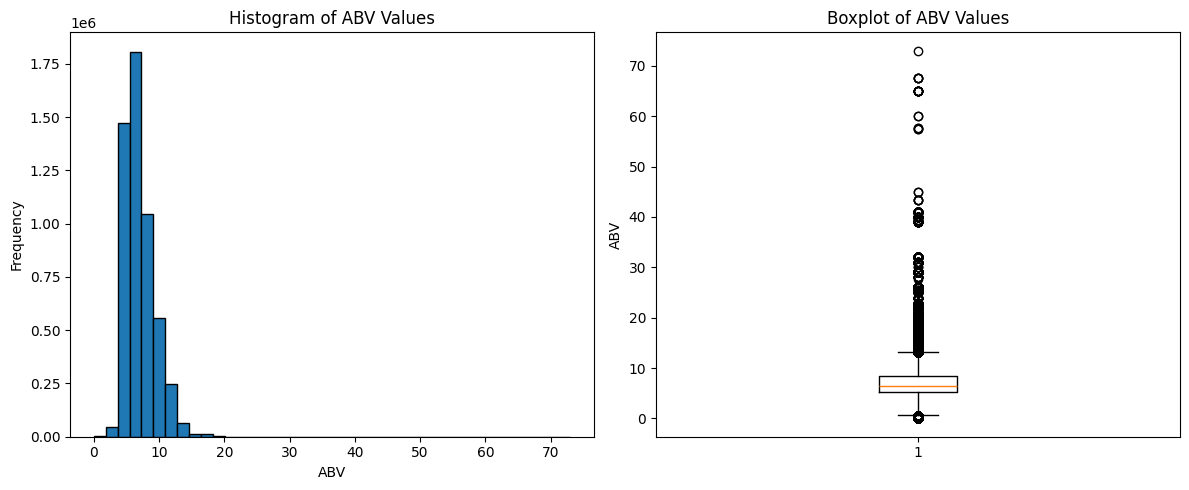

In [171]:
# Create a figure with two subplots (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Create a histogram
ax1.hist(ratings_combined_df['abv'], bins=40, edgecolor='black')  # You can adjust the number of bins as needed
ax1.set_title('Histogram of ABV Values')
ax1.set_xlabel('ABV')
ax1.set_ylabel('Frequency')

# Create a boxplot
abv_values = ratings_combined_df['abv'].dropna()
boxplot = ax2.boxplot(abv_values)
ax2.set_title('Boxplot of ABV Values')
ax2.set_ylabel('ABV')

# Adjust spacing between subplots
plt.tight_layout()

# Show the combined plot
plt.show()

We thus look at the median value as it's more robust to extreme values than the mean Here, the median ABV value of 6.5%, tells us that half of the beers have ABV that are below this value, and the other half have ABV above it.

In [172]:
# Display number of beers with high abv scores
# Define the ABV thresholds
abv_thresholds = [0, 5, 10, 15, 20, 30, 40, 50, 60]

# Count the number of beers above each threshold
for threshold in abv_thresholds:
    count_above_threshold = (ratings_combined_df['abv'] > threshold).sum()
    print(f"Number of beers above {threshold} ABV: {count_above_threshold}")

Number of beers above 0 ABV: 5272089
Number of beers above 5 ABV: 4188982
Number of beers above 10 ABV: 478997
Number of beers above 15 ABV: 19654
Number of beers above 20 ABV: 1580
Number of beers above 30 ABV: 279
Number of beers above 40 ABV: 111
Number of beers above 50 ABV: 20
Number of beers above 60 ABV: 14


In [173]:
# analyzing why some abv scores are that high
# Filter the DataFrame to get examples with ABV over 40
high_abv_examples = beers_ba_df[beers_ba_df['abv'] > 40]

# Display the examples
print("Examples with ABV over 40:")
print(high_abv_examples[['abv', 'beer_name']].head())

Examples with ABV over 40:
        abv                      beer_name
2010   41.0             Sink The Bismarck!
2021   55.0             The End Of History
2050   65.0                     Armageddon
2059   67.5                    Snake Venom
41539  43.0  Schorschbräu Schorschbock 43%


**Conclusion** : 
* We can observe that there are many outliers, beers that have a very high ABV. Some of them might be quite popular amongst a small group of people, such as [Snake Venom](https://www.fooddive.com/news/strongest-beer-in-the-world-snake-venom-sports-675-abv/185830/)
that is officially the world's strongest beer at an ABV of 67.5. 

2. ABV ratings VS the number of ratings

Since the volume is a float value, we will bin it to have categorical bins. It will simplify our analysis and make an approximation result. 

In [174]:
bin_width = 2

# Create a working copy
ratings_abv_number = pd.DataFrame.copy(ratings_combined_df)

# Binning the 'abv' data
ratings_abv_number['abv_bins'] = pd.cut(ratings_abv_number['abv'], bins=range(0, int(ratings_abv_number['abv'].max()) + bin_width, bin_width))

# Grouping and aggregating data
grouped_data = ratings_abv_number.groupby('abv_bins').agg(
    mean_rating=('rating', 'mean'),  # Calculate the mean rating
    count=('rating', 'count')        # Count the number of ratings
).reset_index()

# Handle zero counts by adding a small value before applying the logarithm
grouped_data['count_log'] = grouped_data['count'].apply(lambda x: np.log(x + 1))  # Adding 1 to count to avoid log(0)

# Normalize the count_log and map it to the color scale
min_count_log = grouped_data['count_log'].min()
max_count_log = grouped_data['count_log'].max()
# Create a Plotly figure
fig = go.Figure()

# Add a bar trace for the mean ratings
fig.add_trace(go.Bar(
    x=grouped_data['abv_bins'].astype(str),  # Convert to string for better axis representation
    y=grouped_data['mean_rating'],           # Use mean rating for the bar height
    text=grouped_data['count']              # Number of beers in each bin
))

# Update layout
fig.update_layout(
    title='Relationship between ABV and Average Rating',
    xaxis_title='Alcohol by Volume Bins',
    yaxis_title='Average Rating',
    xaxis={'tickangle': 45},
    yaxis=dict(range=[0, grouped_data['mean_rating'].max() + 0.5]), 
    showlegend=False
)

# Add the count as text on each bar
fig.update_traces(texttemplate='n=%{text}', textposition='outside')

# Show the figure
fig.show()


![](plots/abv_bins_rating.png)

We are able to observe that there is high variability in the number of ratings, however that rating score doesn't vary as much. We will have to pay attention to this when determining the most popular abv score.

We have the relation between average rating and the volume % of alcohol. Let's now add another variable, the **number of ratings**. Indeed, as stated above, the popularity of a beer is a combination of the number of good ratings and its average rating. Let's determine the number of good rating per abv_bin.

First, let's see the relation with the number of ratings.

In [175]:
# Create working copy
binned_ratings_comb_df = pd.DataFrame.copy(ratings_combined_df)

# Create bins for 'abv' with a size of 0.5
binned_ratings_comb_df['abv_binned'] = pd.cut(binned_ratings_comb_df['abv'], bins=np.arange(0, binned_ratings_comb_df['abv'].max() + 0.5, 0.5))

# Create bins for 'rating' with a size of 0.2
rating_bin_size = 0.2
binned_ratings_comb_df['rating_binned'] = pd.cut(binned_ratings_comb_df['rating'], bins=np.arange(0, 6, rating_bin_size))

# Calculate the number of ratings for each combination of binned 'abv' and 'rating'
ratings_count_binned = binned_ratings_comb_df.groupby(['abv_binned', 'rating_binned']).size().reset_index(name='num_ratings')

# Convert intervals to strings for Plotly compatibility
ratings_count_binned['abv_binned'] = ratings_count_binned['abv_binned'].astype(str)
ratings_count_binned['rating_binned'] = ratings_count_binned['rating_binned'].astype(str)

# Create the heatmap with binned ABV values using Plotly
fig = px.density_heatmap(
    ratings_count_binned, 
    x='abv_binned', 
    y='rating_binned', 
    z='num_ratings', 
    color_continuous_scale="YlGnBu"
)

# Customize the plot layout
fig.update_layout(
    title="Heatmap of ABV vs Ratings",
    xaxis_title="ABV",
    yaxis_title="Ratings",
    xaxis=dict(
        tickmode='array',
        tickvals=[6, 12, 18, 24, 30],  # Custom positions for x-axis ticks
        ticktext=['3', '6', '9', '12', '15'],  # Custom labels for x-axis ticks
        range=[0, 30]  # Limit x-axis for zoom on central values
    ),
    yaxis=dict(
        tickmode='array',
        tickvals=[5, 10, 15, 20, 25],  # Custom positions for y-axis ticks
        ticktext=['1', '2', '3', '4', '5']  # Custom labels for y-axis ticks
    ),
    coloraxis_colorbar=dict(
        title="Number of Ratings" 
    )
)

fig.show()

![](plots/heatmap_abv_rating.png)

As observed above, the plot shows high number of ratings for beers that have an alcohol volume between 5 to 10%. This result makes sense, since the known **popular** beer have an alcohol volume in this range. 

For the average rating, we see a higher variation for beers that have between 4.5 and 5 % of alcohol.

3. Regression task 

Let's quantify our observation: is there real causality between alcohol % and the rating it gets. 

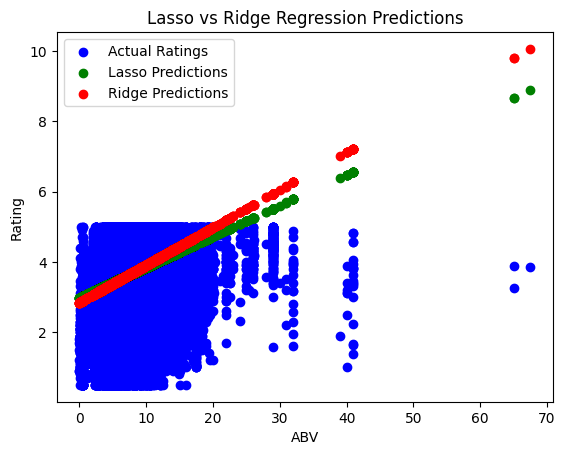

Lasso Regression RMSE: 0.644015430091954, R2: 0.1202925456998103
Ridge Regression RMSE: 0.6425456839102784, R2: 0.12430323009055211


In [176]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score

# Cleaning the data
ratings_combined_df_clean = ratings_combined_df.dropna(subset=['abv'])

# Assuming ratings_combined_df_clean is your DataFrame
X = ratings_combined_df_clean[['abv']]  # Predictor
y = ratings_combined_df_clean['rating']  # Response

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Lasso Regression
lasso_model = Lasso(alpha=0.1)  # Alpha value can be adjusted
lasso_model.fit(X_train, y_train)
lasso_pred = lasso_model.predict(X_test)

# Ridge Regression
ridge_model = Ridge(alpha=1.0)  # Alpha value can be adjusted
ridge_model.fit(X_train, y_train)
ridge_pred = ridge_model.predict(X_test)

# Evaluating the models
lasso_rmse = mean_squared_error(y_test, lasso_pred, squared=False)
ridge_rmse = mean_squared_error(y_test, ridge_pred, squared=False)

lasso_r2 = r2_score(y_test, lasso_pred)
ridge_r2 = r2_score(y_test, ridge_pred)

# Plotting results
plt.scatter(X_test, y_test, color='blue', label='Actual Ratings')
plt.scatter(X_test, lasso_pred, color='green', label='Lasso Predictions')
plt.scatter(X_test, ridge_pred, color='red', label='Ridge Predictions')
plt.title('Lasso vs Ridge Regression Predictions')
plt.xlabel('ABV')
plt.ylabel('Rating')
plt.legend()
plt.show()

# Results
print(f"Lasso Regression RMSE: {lasso_rmse}, R2: {lasso_r2}")
print(f"Ridge Regression RMSE: {ridge_rmse}, R2: {ridge_r2}")


**Interpretation** : 
1. **Lasso Regression**: RMSE of 0.6440 indicates moderate prediction accuracy; R2 of 0.1203 suggests the model explains about 12% of the variance in ratings, indicating a limited predictive power.

2. **Ridge Regression**: Slightly lower RMSE of 0.6425 implies marginally better accuracy; R2 of 0.1243 shows a similar, modest explanatory capability.

**Conclusion**: 
* Both models demonstrate limited effectiveness in predicting beer ratings from ABV alone. Therefore, we cannot significantly state that there is any causality property between the two variables. 

4. ABV with respect to time : ABV dynamics and seasonality

Let's now start to focus on our main objective: can we observe any **seasonality** in terms of ABV ? 

In [177]:
# Group by year_month and calculate the average ABV for each month
average_month_abv = ratings_combined_df.groupby('year_month')['abv'].mean()

# creating a plot showing the average abv per month according to the number of reviews
fig = px.line(average_month_abv, x=average_month_abv.index, y=['abv'], title='Average Alcohol Percentage per Month per Year')
fig.update_xaxes(title_text='Year-Month')
fig.update_yaxes(title_text='Average ABV')

# Calculate a rolling average
smoothed_abv = average_month_abv.rolling(window=6).mean()  # Adjust the window size as needed
# Add the smoothed curve using Plotly Graph Objects
fig.add_trace(go.Scatter(x=average_month_abv.index, y=smoothed_abv, mode='lines', name='Smoothed', line=dict(color='red', dash='dot')))

fig.update_layout(showlegend=False)

# Show the plot
fig.show()

![](plots/abv_monthly_rating.png)

Interestingly, we are able to observe a trend in average ABV that slightly increases over the years, but most of all seems to repeat itself annually. We see similar fluctuations between the years, indicating a seasonality of beers'r ABV.

Visually, we see convincing results, but let's quantify our findings by doing a ANOVA test validating the seasonality of ABV.

In [71]:
# Define the bin size
bin_size = 0.5

# Work on a copy
ratings_combined_df_bins = pd.DataFrame.copy(ratings_combined_df)

# Create a new column 'abv_bins' with bins of size 0.5
ratings_combined_df_bins['abv_bins'] = (ratings_combined_df_bins['abv'] // bin_size) * bin_size

# Group by 'abv_bins' and 'month'
abv_ratings_yearly = ratings_combined_df_bins.groupby(['abv_bins', 'month'])['rating']

# Collect the grouped ABV values for each month into a list
grouped_data = [group.values for name, group in abv_ratings_yearly]

# Perform the ANOVA test
result_anova, p_anova = f_oneway(*grouped_data)

print('p-value for ANOVA test:', p_anova)
print('F-statistic for ANOVA test:', result_anova)


p-value for ANOVA test: 0.0
F-statistic for ANOVA test: 1449.795563956773


**Interpetation:**

* Assuming here that : 
    * Null Hypothesis: There is no significant difference in the abv across months.
    * Alternative Hypothesis (H1): There is a significant difference in the abv across at least two months.

* The results of the ANOVA test indicate that there are statistically significant differences in ABV values between at least two months. This suggests that the ABV values vary significantly across different months, and there is some underlying factor (e.g., seasonality) that might be influencing these differences.

5. Mean percentage of alcohol per month over the years

Let's observe the most consumed alcohol percentage per month. To do that, we group by month on the ABV attribute. Since ratings state the ABV of the beer that is rated, by analyzing the average ABV we directly analyze the ABV that has been the most rated, thus the most consumed at that month.

In [178]:
# creating a new dataframe with the number of ratings per year_month
year_month_abv_df = pd.DataFrame({'year_month': average_month_abv.index, 'mean_abv': average_month_abv.values})

# create column year and month
year_month_abv_df['year'] = year_month_abv_df['year_month'].dt.year
year_month_abv_df['month'] = year_month_abv_df['year_month'].dt.month

# keep only rows where the year is greater than 2008 and less than 2017 
year_month_abv_filtered = year_month_abv_df[(year_month_abv_df.year >= 2008) & (year_month_abv_df.year < 2017)]

# compute the mean number of ratings per month
mean_abv_per_month = year_month_abv_filtered.groupby('month')['mean_abv'].mean().reset_index(name='mean_abv')

# plot with plotly the mean number of ratings per month
fig = px.line(year_month_abv_filtered, x='month', y='mean_abv', color='year', title='Mean Percentage of Alcohol per Month (from 2008 to 2016)')
fig.add_trace(go.Scatter(x=year_month_abv_filtered.month, y=mean_abv_per_month.mean_abv, mode='lines', name='Mean abv', line=dict(color='black', dash='dash', width=4)))

fig.show()

![](plots/abv_mean_rating.png)

EUREKA ! We observe a nice increase of the ABV average at the end and beginning of the year, thus from November to February. It clearly decreases on the other months. 

This result emphasizes the high volume of alcohol consumed during the festivities of the end of the year, such as Christmas and New Years Eve. 

Let's redo our heatmap but showing the most **popular** ABV with respect to number of good ratigns and average ratings. 

In [179]:
# Create working copy
binned_ratings_comb_df = pd.DataFrame.copy(ratings_combined_df)

# Create bins for 'abv' with a size of 0.5
binned_ratings_comb_df['abv_binned'] = pd.cut(binned_ratings_comb_df['abv'], bins=np.arange(0, binned_ratings_comb_df['abv'].max() + 0.5, 0.5))

# Create bins for 'rating' with a size of 0.2
rating_bin_size = 0.2
binned_ratings_comb_df['rating_binned'] = pd.cut(binned_ratings_comb_df['rating'], bins=np.arange(0, 6, rating_bin_size))

# Initialize subplot figure
fig = make_subplots(rows=3, cols=4, subplot_titles=[f'Month {i+1}' for i in range(12)])

for month in range(1, 13):
    # Filter the DataFrame for the specified month
    month_df = binned_ratings_comb_df[binned_ratings_comb_df['month'] == month]

    # Calculate the number of good ratings for each combination of binned 'abv' and 'rating'
    month_df['is_good'] = month_df['rating'] >= month_df['rating'].mean()
    good_ratings_count_binned = month_df[month_df['is_good']].groupby(['abv_binned', 'rating_binned']).size().reset_index(name='num_good_ratings')

    # Convert intervals to strings for Plotly compatibility
    good_ratings_count_binned['abv_binned'] = good_ratings_count_binned['abv_binned'].astype(str)
    good_ratings_count_binned['rating_binned'] = good_ratings_count_binned['rating_binned'].astype(str)

    # Add heatmap for each month
    if month != 1:
        fig.add_trace(
            go.Heatmap(
                x=good_ratings_count_binned['abv_binned'], 
                y=good_ratings_count_binned['rating_binned'], 
                z=good_ratings_count_binned['num_good_ratings'], 
                colorscale="YlGnBu",
                showscale = False
            ),
            
            row=(month-1)//4 + 1, 
            col=(month-1)%4 + 1
        )
    else:
        fig.add_trace(
            go.Heatmap(
                x=good_ratings_count_binned['abv_binned'], 
                y=good_ratings_count_binned['rating_binned'], 
                z=good_ratings_count_binned['num_good_ratings'], 
                colorscale="YlGnBu",
                showscale = True,
            ),
            
            row=(month-1)//4 + 1, 
            col=(month-1)%4 + 1
        )

# Customize the plot layout
fig.update_layout(
    title="Monthly Heatmaps of Good Reviews for ABV vs Ratings",
    height=1200, width=1200,
    xaxis_title="ABV",
    yaxis_title="Ratings",
    coloraxis_colorbar=dict(title="Number of Good Ratings")
)

# Update x-axis and y-axis for all subplots
for i in range(1, 13):
    fig.update_xaxes(
        row=(i-1)//4 + 1, col=(i-1)%4 + 1,
        tickmode='array',
        tickvals=[6, 12, 18, 24, 30],
        ticktext=['3', '6', '9', '12', '15'],
        range=[0, 30]
    )
    fig.update_yaxes(
        row=(i-1)//4 + 1, col=(i-1)%4 + 1,
        tickmode='array',
        tickvals=[5, 10, 15, 20, 25],
        ticktext=['1', '2', '3', '4', '5']
    )


fig.show()

![](plots/heatmap_rating_abv_monthly.png)

In general, we don't see a lot of variations between months. But still, if we observe more precisely the months of January and December, the number of good ratings becomes large for more beers with higher alcohol volume. 

### Finally, what are the preferred ABV for beers ? 

Let's code a function that will retrieve the most **popular** ABV with respect to the number of good ratings it received and its average rating.

In [180]:
def find_abv_by_month(df, month, good=True):
    # Filter the DataFrame for the specified month
    month_df = df[df['month'] == month]

    # Create bins for 'abv' with a size of 0.2
    month_df['abv_binned'] = pd.cut(month_df['abv'], bins=np.arange(0, month_df['abv'].max() + 0.2, 0.2))

    # separate the dataframe into two dataframes for BeerAdvocate and RateBeer
    month_df_ba = month_df[month_df['dataset'] == 'BeerAdvocate']
    month_df_rb = month_df[month_df['dataset'] == 'RateBeer']

    # compute average of category
    average_ba = month_df_ba['rating'].mean()
    average_rb = month_df_rb['rating'].mean()
    
    # Assign 'is_good' based on average rating
    month_df_ba.loc[:, 'is_good'] = month_df_ba['rating'] >= average_ba
    month_df_rb.loc[:, 'is_good'] = month_df_rb['rating'] >= average_rb

    # concatenate the two dataframes
    month_df = pd.concat([month_df_ba, month_df_rb], ignore_index=True)

    # Group by 'abv_binned' and aggregate
    beer_df = month_df.groupby('abv_binned').agg(average_rating=('rating', 'mean'), 
                                                 total_review_count=('rating', 'count'),
                                                 good_review_count=('is_good', 'sum')).reset_index()

    # Sort and filter based on condition
    if good:
        beer_stats = beer_df.sort_values(by=['good_review_count', 'average_rating'], ascending=[False, False])
    else:
        beer_stats = beer_df[beer_df['total_review_count'] >= 100].sort_values(by=['average_rating'], ascending=True)

    # Get the abv bin for the month
    abv_bin = beer_stats.iloc[0]['abv_binned']
    
    # print the best abv bin for the month
    #print(f"ABV Bin for the month of {month}:", abv_bin)

    return abv_bin

In [181]:
# Extraction of the value of the calculated abv bins
# Initialize an empty list to store the results
results = []

# Create a copy of the Dataframe
ratings_abv =pd.DataFrame.copy(ratings_combined_df)

# Iterate through the unique months in the DataFrame
unique_months = ratings_abv['month'].unique()
for month in unique_months:
    favorite_abv_bin = find_abv_by_month(ratings_abv, month)
    
    # Extract the higher bound of the bin as a numeric value
    higher_bound = favorite_abv_bin.right
    
    # Append the result to the results list
    results.append({'Month': month, 'Favorite ABV Bin': favorite_abv_bin, 'abv': higher_bound})

# Create a DataFrame from the results list
favorite_abv_higher_bound_df = pd.DataFrame(results)

# Sort the DataFrame in increasing order based on the 'Higher Bound' column
favorite_abv_higher_bound_df = favorite_abv_higher_bound_df.sort_values(by='Month')

# Reset the index of the sorted DataFrame
favorite_abv_higher_bound_df = favorite_abv_higher_bound_df.reset_index(drop=True)


# Print the resulting DataFrame
print(favorite_abv_higher_bound_df)

    Month Favorite ABV Bin  abv
0       1       (7.8, 8.0]  8.0
1       2       (7.8, 8.0]  8.0
2       3       (7.8, 8.0]  8.0
3       4       (7.8, 8.0]  8.0
4       5       (7.8, 8.0]  8.0
5       6       (4.8, 5.0]  5.0
6       7       (4.8, 5.0]  5.0
7       8       (4.8, 5.0]  5.0
8       9       (5.8, 6.0]  6.0
9      10       (5.8, 6.0]  6.0
10     11       (7.8, 8.0]  8.0
11     12       (7.8, 8.0]  8.0


In [197]:
# Extracting the min and max values from the 'ABV Bin' column
favorite_abv_higher_bound_df['min_bin'] = favorite_abv_higher_bound_df['Favorite ABV Bin'].apply(lambda x: x.left)
favorite_abv_higher_bound_df['max_bin'] = favorite_abv_higher_bound_df['Favorite ABV Bin'].apply(lambda x: x.right)

# Creating a column for the average between min and max
favorite_abv_higher_bound_df['average_bin'] = (favorite_abv_higher_bound_df['min_bin'] + favorite_abv_higher_bound_df['max_bin']) / 2

# Creating the line plot
fig = go.Figure()

# Adding the line plot with the average
fig.add_trace(go.Scatter(
    x=favorite_abv_higher_bound_df['Month'],
    y=favorite_abv_higher_bound_df['average_bin'],
    mode='lines',
    name='Best ABV',
    line=dict(color='green')
))

# Adding the shaded area for margin of error
fig.add_trace(go.Scatter(
    x=list(favorite_abv_higher_bound_df['Month']) + list(favorite_abv_higher_bound_df['Month'][::-1]),
    y=list(favorite_abv_higher_bound_df['max_bin']) + list(favorite_abv_higher_bound_df['min_bin'][::-1]),
    fill='toself',
    fillcolor='rgba(0,100,80,0.2)',
    line=dict(color='rgba(255,255,255,0)'),
    name='Margin of Error'
))

# Updating layout
fig.update_layout(
    title='Most Popular ABV with Margin of Error',
    xaxis=dict(title='Month'),
    yaxis=dict(title='ABV'),
    showlegend=True
)

# Show the plot
fig.show()


![](plots/best_abv.png)

We see clear differences between early months and ending month, where the approximate alcohol volume is near the 8%. For months such as June and July, the % of alcohol volume preferred is 5 % which is way lower. 

As done previously, let's quantify our findings. We apply a t-test to compare between beers that have the % of alcohol preferred and the beers that don't for each month. 

In [82]:
def compare_abv_preference_per_month(favorite_abv_df, ratings_df):
    results = []

    for index, row in favorite_abv_df.iterrows():
        month = row['Month']
        favored_abv = row['abv']

        # Filter the ratings for the given month
        month_ratings = ratings_df[ratings_df['month'] == month]

        # Ratings for the favored ABV
        favored_ratings = month_ratings[month_ratings['abv'] == favored_abv]['rating']

        # Ratings for other ABVs
        other_ratings = month_ratings[month_ratings['abv'] != favored_abv]['rating']

        # Perform t-test
        t_stat, p_value = ttest_ind(favored_ratings, other_ratings, equal_var=False)

        # Determine if the result is significant
        significance = p_value < 0.05
        result = {
            'Month': month,
            'Favored_ABV': favored_abv,
            't_stat': t_stat,
            'p_value': p_value,
            'is_significant': significance
        }
        results.append(result)

    return pd.DataFrame(results)

In [83]:
compare_abv_preference_per_month(favorite_abv_higher_bound_df,ratings_combined_df)

Month  Favored_ABV     t_stat       p_value  is_significant
0       1          8.0  43.484420  0.000000e+00            True
1       2          8.0  42.479767  0.000000e+00            True
2       3          8.0  43.683490  0.000000e+00            True
3       4          8.0  43.453805  0.000000e+00            True
4       5          8.0  46.051013  0.000000e+00            True
5       6          5.0 -68.319776  0.000000e+00            True
6       7          5.0 -70.590439  0.000000e+00            True
7       8          5.0 -71.194225  0.000000e+00            True
8       9          6.0   5.742843  9.437893e-09            True
9      10          6.0   2.605183  9.188578e-03            True
10     11          8.0  42.410868  0.000000e+00            True
11     12          8.0  42.103202  0.000000e+00            True

We perform a t-test to determine if there is significant evidence for the favorite ABV per month:

**Null Hypothesis:** 
* There is not sufficient difference between the popularity of the favorite abv compared to other abv in the given month.<br>
**Alternative Hypothesis:** 
* There is sufficient difference between the popularity of the favorite abv compared to other abv in the given month.<br>

**Conclusion:** 
* The table suggests that there is strong statistical evidence to conclude that the favorite ABV for each month is significantly different from the popularity of other ABV values in that same month. This suggests that certain ABV values (5.0 or 8.0) are consistently preferred in different months, and these preferences are statistically significant.

## Preferred Aroma, Taste, Appearance and Palate ! 

Let's delve into the **4 senses** of our consumers preferences ! 

Each beer has a specific taste, aroma or appearance. As we want to create the best combination for a beer, we seek to extract the adjectives or nouns describing the aroma, taste, appearance or palate of the most popular beer. 

As a first step, we need to create a list of words for each of these categories. To do so, we extract the words that appear the most frequently around the nouns/synonyms of those categories in the textual reviews.

1. Keywords extraction

In [42]:
textual_ratings_df = ratings_combined_df.copy()

# drop the rows where the text is null
textual_ratings_df.dropna(subset=['text'], inplace=True)

# Keywords for each category : similar words are grouped together  
aroma_keywords = ['aroma', 'smell', 'fragrance', 'scent', 'finish']
taste_keywords = ['taste', 'flavor', 'palate']
palate_keywords = ['palate', 'mouthfeel', 'body', 'texture', 'feel']
appearance_keywords = ['appearance', 'color', 'look', 'pour', 'head', 'foam', 'lacing']
carbonation_keywords = ['carbonation', 'bubbles', 'fizz', 'carbonated']

# group by beer_id and count the number of reviews for each beer
beer_reviews_count = textual_ratings_df.groupby('new_id_beer').count()['text'].reset_index()

beer_reviews_count['text'].describe()

count    374688.000000
mean         14.559788
std          76.417297
min           1.000000
25%           1.000000
50%           2.000000
75%           6.000000
max        3719.000000
Name: text, dtype: float64

The average of ratings received for a beer is 16.46, rounded to 14, with a standard deviation of 89.74. 
Since we have a lot of beers, and some of them receive a large amount of reviews, we decide to threshold the reviews. 
We assume that, in general, beers receive kind of the same review when it is a good review, and same goes for bad reviews. That's why we split the reviews into two parts, so that we can construct dictionnaries for good and for bad reviews.

Let's keep a maximum review of 17 for each beer. 

In [43]:
# for each beer_id, keep a maximum sample of mean reviews
mean = 17
beer_reviews_sample = textual_ratings_df.groupby('new_id_beer').apply(lambda x: x.sample(min(len(x), mean))).reset_index(drop=True)

nlp = spacy.load('en_core_web_sm')

def extract_keywords(text, keywords):
    # Process the text with spaCy
    doc = nlp(text.lower())

    result = []
    for token in doc:
        if token.text.lower() in keywords:
            # Collect nearby adjectives and nouns
            nearby_words = []
            for nearby_token in doc[token.i - 3:token.i + 5]:
                if nearby_token.pos_ in ['ADJ', 'NOUN'] and not nearby_token.is_stop and len(nearby_token) > 2:
                    nearby_words.append(nearby_token.lemma_)
            result.extend(nearby_words)
            
    # remove the duplicates and the words that are in the keywords list
    result = list(set(result) - set(keywords))

    return result

In [44]:
# concatenate all the keywords aroma_keywords, taste_keywords, palate_keywords, appearance_keywords, carbonation_keywords
all_keywords = aroma_keywords + taste_keywords + palate_keywords + appearance_keywords + carbonation_keywords

# create a function to filter the keys from the dictionary
def filter_keywords(keywords):
    filtered_keywords = []
    
    for keyword in keywords:
        
        # remove the keyowrds that have special characters, numbers and punctuation
        if not re.match('^[a-zA-Z]+$', keyword):
            continue
        
        # remove the keywords that are less than 3 characters
        if len(keyword) < 3:
            continue
        
        # remove keywords that have the word 'beer' in them
        if keyword == 'beer':
            continue
        
        # remove keywords such as not, like, well, etc.
        if keyword in ['not', 'one', 'like', 'well', 'good', 'great', 'nice', 'little', 'much', 'really', 'bit', 'very', 'with', 'more', 'and', 'but', 'too', 'also', 'just']:
            continue
        
        # remove words such as hop, hoppy, malt, malty, etc.
        if keyword in ['hop', 'hops', 'hoppy', 'malt', 'malts', 'malty', 'maltiness', 'maltinesses']:
            continue
        
        # if the keyword is not in the all_keywords list, add it to the filtered_keywords list
        if keyword not in all_keywords:
            filtered_keywords.append(keyword)
    
    return filtered_keywords

Let's start our extraction with the use of the two previous function. 

Since it has been done previously and takes quite a large amount of time, the following cells concerning the extraction of the most frequent kexwords for each category will be commented. The dictionnaries were saved in json files, and when needed they loaded. 

In [45]:
# good_aroma_list = []
# good_taste_list = []
# good_palate_list = []
# good_appearance_list = []
# good_carbonation_list = []

# sample_reviews = beer_reviews_sample['text'].sample(100000)

# for i, text in enumerate(sample_reviews.values):
#     # for each keyword list, extract the keywords from the text
#     good_aroma_list.extend(extract_keywords(text, aroma_keywords))
#     good_taste_list.extend(extract_keywords(text, taste_keywords))
#     good_palate_list.extend(extract_keywords(text, palate_keywords))
#     good_appearance_list.extend(extract_keywords(text, appearance_keywords))
#     good_carbonation_list.extend(extract_keywords(text, carbonation_keywords))
    
#     aroma_set = Counter(good_aroma_list)
#     taste_set = Counter(good_taste_list)
#     palate_set = Counter(good_palate_list)
#     appearance_set = Counter(good_appearance_list)
#     carbonation_set = Counter(good_carbonation_list)
    
#     if i % 1000 == 0:
#         # save it into json files
#         with open('data/aroma_keywords.json', 'w') as f:
#             json.dump(aroma_set, f)
        
#         with open('data/taste_keywords.json', 'w') as f:
#             json.dump(taste_set, f)
        
#         with open('data/palate_keywords.json', 'w') as f:
#             json.dump(palate_set, f)
        
#         with open('data/appearance_keywords.json', 'w') as f:
#             json.dump(appearance_set, f)
        
#         with open('data/carbonation_keywords.json', 'w') as f:
#             json.dump(carbonation_set, f)
            
#         print("File saved at iteration", i)

In [46]:
# # filter the keywords
# aroma_words = filter_keywords(aroma_set.keys())
# taste_words = filter_keywords(taste_set.keys())
# palate_words = filter_keywords(palate_set.keys())
# appearance_words = filter_keywords(appearance_set.keys())
# carbonation_words = filter_keywords(carbonation_set.keys())

# # reconstruct the dictionaries with the filtered keywords
# aroma_dict = {key: aroma_set[key] for key in aroma_words}
# taste_dict = {key: taste_set[key] for key in taste_words}
# palate_dict = {key: palate_set[key] for key in palate_words}
# appearance_dict = {key: appearance_set[key] for key in appearance_words}
# carbonation_dict = {key: carbonation_set[key] for key in carbonation_words}

Here are our cleaned list of frequent keywords for each category : 

In [47]:
# keep only the keywords that appear more than 100 times
appearance_terms = ['white', 'brown', 'light', 'small', 'thin', 'dark', 'golden', 'retention', 'medium', 'hazy', 'clear', 
                            'amber', 'black', 'creamy', 'thick', 'beige', 'orange', 'yellow', 'tan', 'foamy', 'copper', 'big', 
                            'gold', 'decent', 'deep', 'cloudy', 'lace', 'moderate', 'red', 'minimal', 
                            'ring', 'bright', 'colored', 'straw', 'dense', 'reddish', 'pale', 'khaki', 
                            'slight', 'rich', 'huge', 'fizzy', 'frothy', 'solid', 'average', 
                            'short', 'bubble', 'caramel', 'soft', 'pink', 'mocha', 'opaque', 'murky', 'ruby',
                            'rocky', 'fine', 'cling', 'cap', 'mahogany', 'brownish', 'ton', 'hue',  
                            'haze', 'pitch', 'clarity', 'wispy', 'cherry', 'highlight', 'clean', 'fade', 'funky', 
                            'ivory', 'purple', 'lacy', 'bone', 'high', 'hint', 'pinkish', 'peach', 'toffee',  'yellowish', 
                            'patchy', 'bronze', 'muddy', 'firm', 'clingy', 'stringy', 'visible', 'transparent']

taste_terms = ['sweet',  'bitter', 'smooth', 'roasted', 'dry', 'fruity', 'tart', 'bodied', 
    'bitterness', 'sour', 'strong', 'spice', 'mild', 'rich',  'yeast', 'profile', 'sweetness', 'earthy', 'balanced', 'alcohol', 
    'wheat', 'spicy', 'clean', 'moderate', 'crisp', 'grain', 'slight', 'heavy',
    'creamy', 'mid', 'complex', 'hint', 'roasty', 'bready', 'bread', 'roast', 'herbal', 'fresh', 'sugar', 'balance', 
    'solid', 'soft', 'juicy', 'subtle', 'grass', 'grassy', 'smoke',
    'funk', 'nutty', 'character', 'refreshing', 'citrusy', 'belgian', 'decent', 'bittersweet', 
    'rye', 'thick', 'thin', 'piney', 'grainy', 'clove', 'yeasty', 
    'wine', 'molasse', 'ale', 'biscuit', 'funky', 'bud', 'plenty', 'peppery', 'milk', 'barrel', 'tartness', 
    'smoky', 'woody', 'faint', 'toast', 'low', 'stout', 
    'ester', 'ton', 'bold', 'intense', 'deep', 'suit', 'brew', 'tangy', 'whiskey', 'blend', 'peel', 
    'tasty', 'ipa', 'acidic', 'straw', 'boozy', 'fruitiness', 'smokey', 'mellow', 'earthiness', 'juice', 'toasty', 'booze', 
    'average', 'tone', 'dough', 'robust', 'sourness', 'cracker', 'noticeable', 'biscuity', 
    'rind', 'barley', 'lager', 'cream', 'plum', 'acidity',  'hoppiness', 'upfront', 
    'resinous', 'syrup', 'porter', 'vinegar', 'sugary',' bubblegum']

palate_terms = ['medium', 'light', 'smooth', 'creamy', 'dry', 'bodied', 'soft', 
                'thin', 'thick', 'moderate', 'crisp',  'sticky', 'slick', 
                'mid', 'solid', 'decent', 'mild', 'balanced', 'oily', 'chewy', 
                'deep', 'watery', 'silky', 'refreshing', 'strong', 'touch', 'balance', 'fizzy', 'character', 
                'fine', 'flat', 'full', 'hint', 'sharp', 'bready', 'foamy', 
                'viscous', 'chalky', 'effervescent', 'fluffy', 'grainy', 'gentle', 
                'prickly', 'tartness', 'bubbly', 'acidic', 'astringency']

aroma_terms = ['citrus', 'chocolate', 'fruit', 'fruity', 'coffee',  'floral',
    'caramel', 'pine', 'grapefruit', 'tropical', 'vanilla', 'lemon', 'bourbon', 'cherry', 
    'orange', 'herbal', 'decent', 'citrusy', 'cocoa', 'honey', 'oak', 
    'toffee', 'nutty', 'banana', 'grass', 'apple', 
    'pepper', 'pineapple', 'thin', 'funk', 'clove', 'wood', 
    'berry', 'woody', 'biscuit', 'raspberry', 'grape', 'molasse', 
    'tangy', 'barrel', 'peach', 'raisin', 'resinous', 
    'candy', 'ipa',  'nut', 'pungent', 'pumpkin', 'ginger', 
    'mango', 'warming', 'earth', 'mellow', 'cereal', 'ring', 'astringent', 
    'coriander', 'tangerine', 'maple', 'melon', 'hay', 'lactic', 'citric', 
    'peel', 'rind', 'lager', 'bold', 'vinous', 'weak', 'toasted', 'blueberry', 
    'biscuity', 'spiced', 'lime', 'metallic', 'coconut', 'hay'
]

2. Analysis of the attributes 

Let's obseerve the distribution of the ratings of the attributes in the two datasets. 

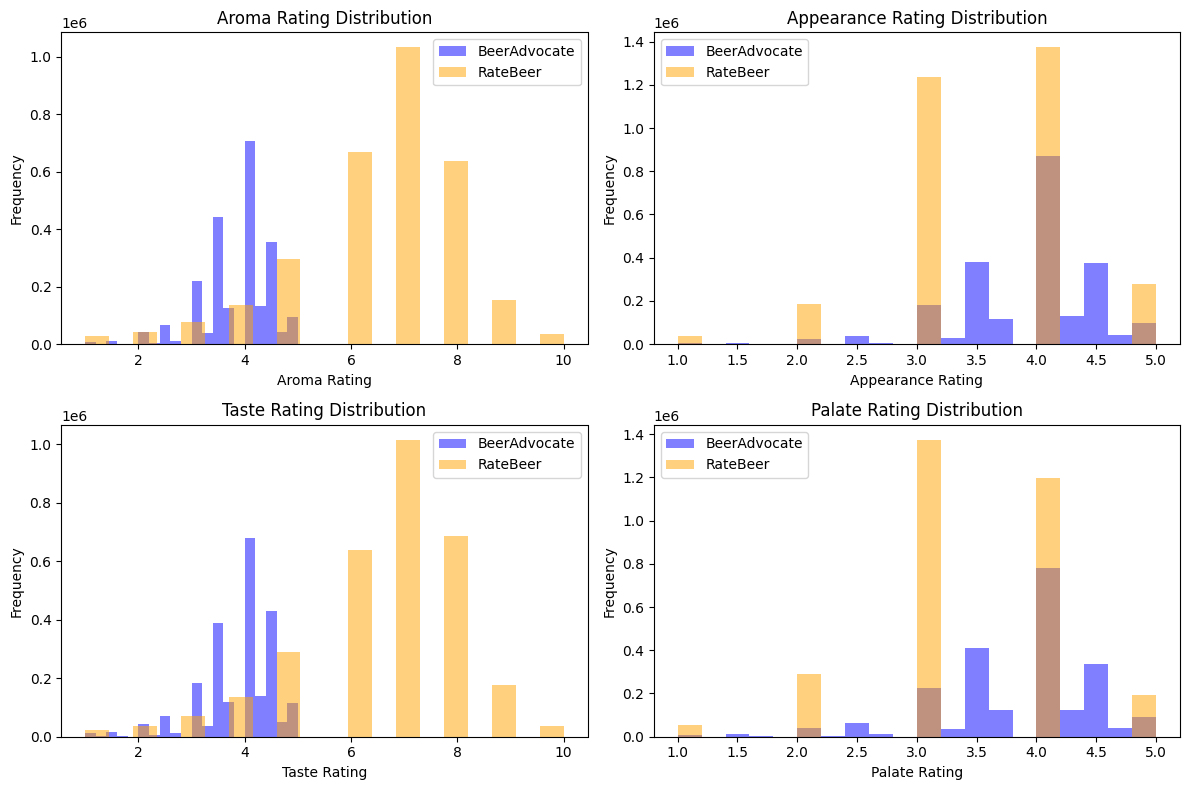

In [48]:
textual_ratings_df_ba = textual_ratings_df[textual_ratings_df['dataset'] == 'BeerAdvocate']
textual_ratings_df_rb = textual_ratings_df[textual_ratings_df['dataset'] == 'RateBeer']

# Plotting histograms for aroma
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.hist(textual_ratings_df_ba['aroma'], bins=20, alpha=0.5, label='BeerAdvocate', color='blue')
plt.hist(textual_ratings_df_rb['aroma'], bins=20, alpha=0.5, label='RateBeer', color='orange')
plt.title('Aroma Rating Distribution')
plt.xlabel('Aroma Rating')
plt.ylabel('Frequency')
plt.legend()

# Plotting histograms for appearance
plt.subplot(2, 2, 2)
plt.hist(textual_ratings_df_ba['appearance'], bins=20, alpha=0.5, label='BeerAdvocate', color='blue')
plt.hist(textual_ratings_df_rb['appearance'], bins=20, alpha=0.5, label='RateBeer', color='orange')
plt.title('Appearance Rating Distribution')
plt.xlabel('Appearance Rating')
plt.ylabel('Frequency')
plt.legend()

# Plotting histograms for taste
plt.subplot(2, 2, 3)
plt.hist(textual_ratings_df_ba['taste'], bins=20, alpha=0.5, label='BeerAdvocate', color='blue')
plt.hist(textual_ratings_df_rb['taste'], bins=20, alpha=0.5, label='RateBeer', color='orange')
plt.title('Taste Rating Distribution')
plt.xlabel('Taste Rating')
plt.ylabel('Frequency')
plt.legend()

# Plotting histograms for palate
plt.subplot(2, 2, 4)
plt.hist(textual_ratings_df_ba['palate'], bins=20, alpha=0.5, label='BeerAdvocate', color='blue')
plt.hist(textual_ratings_df_rb['palate'], bins=20, alpha=0.5, label='RateBeer', color='orange')
plt.title('Palate Rating Distribution')
plt.xlabel('Palate Rating')
plt.ylabel('Frequency')
plt.legend()

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


**Problem**: 
* We observe variations in the ratings method between the two datasets. Especially when we observe the aroma and taste rating, in BeerAdvocate the users rate the beer from 0 to 5. On the other hand, in RateBeer, they rate from 0 to 10. 


**Solutiom**: 
* We can divide the ratings of aroma and taste by respectively 5 for BeerAdvocate ratings and by 10 for RateBeer ratings. Thus, we get a normalized rating which is comparable between the two datasets. 

In [49]:
# for the rows where dataset is BeerAdvocate, add column normalized_aroma
textual_ratings_df.loc[textual_ratings_df['dataset'] == 'BeerAdvocate', 'normalized_aroma'] = textual_ratings_df.loc[textual_ratings_df['dataset'] == 'BeerAdvocate', 'aroma'] / 5
textual_ratings_df.loc[textual_ratings_df['dataset'] == 'RateBeer', 'normalized_aroma'] = textual_ratings_df.loc[textual_ratings_df['dataset'] == 'RateBeer', 'aroma'] / 10

textual_ratings_df.loc[textual_ratings_df['dataset'] == 'BeerAdvocate', 'normalized_taste'] = textual_ratings_df.loc[textual_ratings_df['dataset'] == 'BeerAdvocate', 'taste'] / 5
textual_ratings_df.loc[textual_ratings_df['dataset'] == 'RateBeer', 'normalized_taste'] = textual_ratings_df.loc[textual_ratings_df['dataset'] == 'RateBeer', 'taste'] / 10

Which attribute gives more weight on the final rating ? 

In [50]:
weight_ratings_df = textual_ratings_df.copy()

# drop NA values in normalized_aroma and normalized_taste, palate, appearance
weight_ratings_df.dropna(subset=['normalized_aroma', 'normalized_taste', 'palate', 'appearance'], inplace=True)

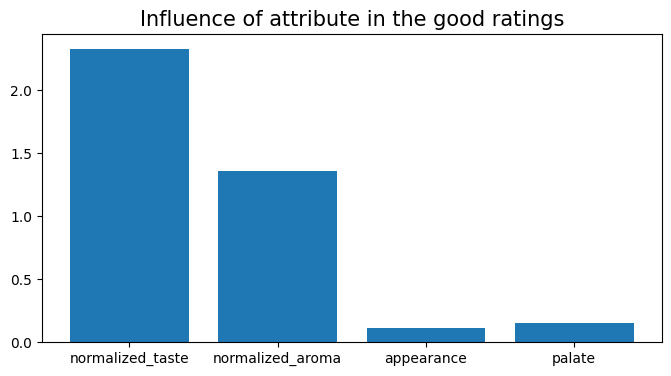

In [51]:
X = weight_ratings_df[['normalized_taste', 'normalized_aroma', 'appearance', 'palate']]
y = weight_ratings_df['rating']


clf = linear_model.LinearRegression(fit_intercept=False)
clf.fit(X, y)
weights = clf.coef_
plt.figure(figsize = (8, 4))
plt.bar(x = ['normalized_taste', 'normalized_aroma', 'appearance', 'palate'], height = weights)
plt.title('Influence of attribute in the good ratings', fontsize=15)
plt.grid(False)
plt.show()

ols = sm.OLS(y, X)
model = ols.fit()

Let's observe if there are any differences between months. Do the weight of the attribute change between months or not ? 

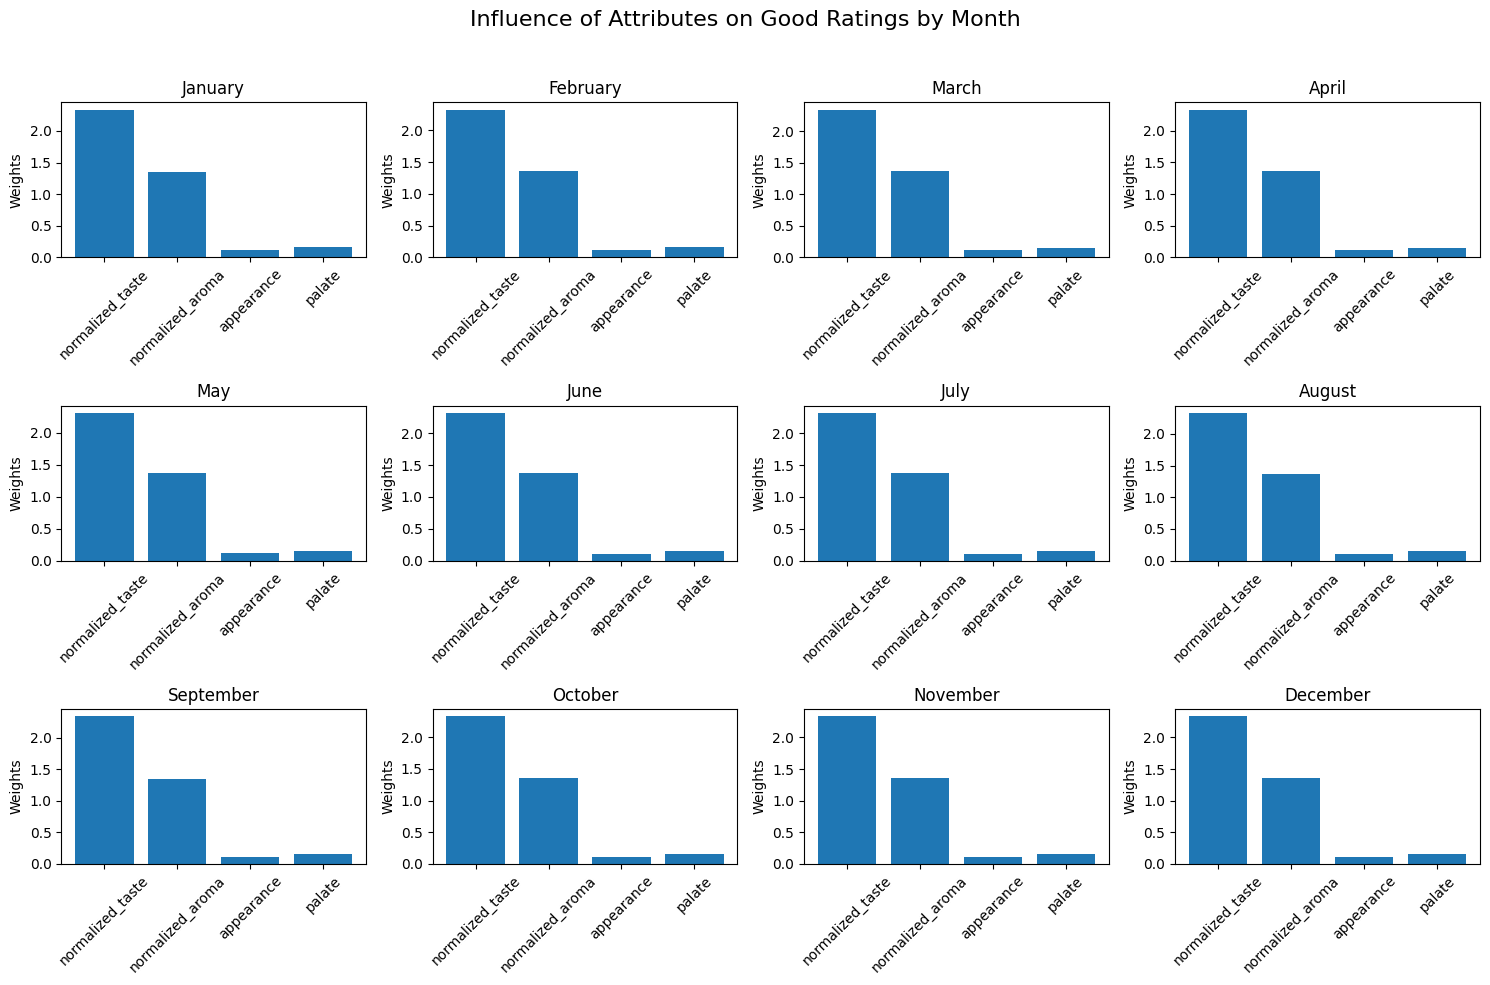

In [53]:
# List of months
months = sorted(weight_ratings_df['month'].unique())

# Set up subplots
fig, axes = plt.subplots(3, 4, figsize=(15, 10))
fig.suptitle('Influence of Attributes on Good Ratings by Month', fontsize=16)

# Flatten the 3x4 subplot grid into a 1D array for iteration
axes = axes.flatten()

for i, month in enumerate(months):
    # Filter data for the current month
    month_df = weight_ratings_df[weight_ratings_df['month'] == month]
    
    # Define X and y for the current month
    X = month_df[['normalized_taste', 'normalized_aroma', 'appearance', 'palate']]
    y = month_df['rating']

    # Linear Regression
    clf = linear_model.LinearRegression(fit_intercept=False)
    clf.fit(X, y)
    weights = clf.coef_

    # Create a bar plot on the current subplot
    axes[i].bar(x=['normalized_taste', 'normalized_aroma', 'appearance', 'palate'], height=weights)
    axes[i].set_title(calendar.month_name[month])
    axes[i].set_ylabel('Weights')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(False)

# Adjust layout to prevent overlapping
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

No differences is absovered through the months. Taste and aroma clearly influence the final rating. They are the most important attributes to focus on, and consumers give more attention to them. 

3. Most frequent keywords in the most popular beer 

Let's now extract the most frequent keywords for each attribute. The most frequent keywords are extracted from the most popular beers ! 

In [96]:
# extract the keywords from the text
def matching_keywords(text, list_keywords):
    # Process the text with spaCy
    doc = nlp(text.lower())

    # Initialize an empty list
    result = []
    for token in doc:
        token = token.lemma_
        if token in list_keywords:
            result.append(token)
    
    return result

We create the following function to extract the best beer according to a rating.

In [95]:
def find_keywords_by_month_traditional(df, keywords_list, month, category, num_keywords, good=True):
    # Filter the DataFrame for the specified month
    month_df = df[df['month'] == month]

    # separate the dataframe into two dataframes: one for BeerAdvocate and one for RateBeer
    month_df_ba = month_df[month_df['dataset'] == 'BeerAdvocate']
    month_df_rb = month_df[month_df['dataset'] == 'RateBeer']
    
    # compute average of category
    average_ba = month_df_ba[category].mean()
    average_rb = month_df_rb[category].mean()
    
    month_df_ba['is_good'] = month_df_ba[category] >= average_ba
    month_df_rb['is_good'] = month_df_rb[category] >= average_rb
    
    month_df_ba['is_good'] = month_df_ba['is_good'].astype(int)
    month_df_rb['is_good'] = month_df_rb['is_good'].astype(int)
    
    # concatenate the two dataframes
    month_df = pd.concat([month_df_ba, month_df_rb], ignore_index=True)

    # Find the best beer for the month based on average rating and review count
    beer_df = month_df.groupby('new_id_beer').agg({category: ['mean', 'count'], 'is_good': 'count'}).reset_index()
    beer_df.columns = ['beer_id', 'average_rating', 'total_review_count', 'good_review_count']
    
    if (good):
        beer_stats = beer_df.sort_values(by=['good_review_count', 'average_rating'], ascending=[False, False])
    else:
        # keep only the beers that have at least 10 reviews
        beer_stats = beer_df[beer_df['total_review_count'] >= 100].sort_values(by=['average_rating'], ascending=True)

    # Get the beer ID of the best beer for the month
    beer_id = beer_stats.iloc[0]['beer_id']
    
    # print the best beer id for the month
    print(f"Beer for the month of {month}:", beer_id)

    # filter the dataframe with the 10 best beers for the month
    beer_reviews = month_df[month_df['new_id_beer'] == beer_id]
    
    # Extract keywords from reviews using a matching function (e.g., matching_keywords)
    keyword_list = []
    for text in beer_reviews['text'].values.tolist():
        keyword_list.extend(matching_keywords(text, keywords_list))

    # Count the number of times each keyword appears in the reviews
    keyword_counter = Counter(keyword_list)

    # Sort the dictionary by value
    sorted_keywords = dict(sorted(keyword_counter.items(), key=lambda item: item[1], reverse=True))

    # Return the top N keywords as a list of tuples (key, value)
    top_keywords = [(key, sorted_keywords[key]) for key in list(sorted_keywords.keys())[:num_keywords]]

    return beer_id, top_keywords

**Aroma Analysis**

Let's observe the most frequent keywords for the aroma attribute that appear for the most popular beer. To select the most popular beer, we first sort by the number of ratings and select the one with the highest average. 

It is also important to verify the validity of the extracted keywords. What if the same keywords appear for another less popular beer? 
To validate our results, we select a less popular beer and extract the most frequent keywords for each month. To select the least popular beer, we could select the one with the lowest number of rating, but this could lead us to only 1 rating, which does not reflect the opinion of a multiple people. Therefore, by a further analysis we observed that a beer receives in average 18 reviews with a standard deviation of approx. 89. Thus, we decide to threshold the beers to the ones having received at least 100 reviews, and among them we select the one with the lowest average rating. 

After this, in order to check whether good keywords are relevant, we will plot for each months and each characteristics the keywords that are used in the good as well as in the bad ratings. This will allow us to decide whether a good keyword describing a characteristic is only used in a good way or if there are also many bad reviews using this keyword in a negative way. In the second option, it would not make sense to select this keyword as best descriptor for a characteristic. Let's see the result.

In [97]:
top_aroma_keywords_by_month = {}
best_aroma_beers = {}

bad_aroma_keywords_by_month = {}
worst_aroma_beers = {}

for month in range(1, 13):
    beer_id, top_aroma_keywords_by_month[month] = find_keywords_by_month_traditional(textual_ratings_df, aroma_terms, month, 'aroma', 10)
    best_aroma_beers[month] = beer_id
    print("Month", month)
    print("Good Aroma Keywords: ")
    print(top_aroma_keywords_by_month[month])
    
    beer_id, bad_aroma_keywords_by_month[month] = find_keywords_by_month_traditional(textual_ratings_df, aroma_terms, month, 'aroma', 10, False)
    worst_aroma_beers[month] = beer_id
    print("Bad Aroma Keywords: ")
    print(bad_aroma_keywords_by_month[month])
    print()

Beer for the month of 1: d2f53c222ed269ba56a088ac5f7b14f5b416df729348fb472b20f41e8fdd4339
Month 1
Good Aroma Keywords: 
[('honey', 1082), ('citrus', 712), ('grapefruit', 651), ('orange', 560), ('pine', 471), ('ipa', 336), ('fruit', 264), ('pineapple', 258), ('floral', 243), ('tropical', 168)]
Beer for the month of 1: 4bc86c3d02a8b5685fdd065fbbf49eec3adc49cc8102118e385f3c85fc3deb4e
Bad Aroma Keywords: 
[('lager', 17), ('thin', 14), ('metallic', 12), ('decent', 10), ('weak', 7), ('hay', 4), ('ring', 2), ('coffee', 2), ('fruit', 2), ('grape', 2)]

Beer for the month of 2: d2f53c222ed269ba56a088ac5f7b14f5b416df729348fb472b20f41e8fdd4339
Month 2
Good Aroma Keywords: 
[('honey', 994), ('citrus', 711), ('grapefruit', 577), ('orange', 552), ('pine', 463), ('ipa', 436), ('fruit', 251), ('floral', 244), ('pineapple', 213), ('tropical', 179)]
Beer for the month of 2: dd0fea1459e7aafd26987e7c907b9b73f93d7265675757f8e07e1bb9a52a0c8a
Bad Aroma Keywords: 
[('thin', 28), ('lager', 19), ('metallic', 13

We can quantify if the two beers (the popular one and least popular one) are statistically different with a t-test.

In [98]:
def test_difference_beers(df, good_df, bad_df, category): 
    for month in range(1, 13):
        # Extract ratings for the two beers in the current month
        ratings_best = df[(df['new_id_beer'] == good_df[month]) & (df['month'] == month)][category]
        ratings_worst = df[(df['new_id_beer'] == bad_df[month]) & (df['month'] == month)][category]

        # Perform the Mann-Whitney U test
        t_statistic, p_value = st.ttest_ind(ratings_best, ratings_worst)

        # Print the results for each month
        print(f'Month: {month}')
        print(f'U-statistic: {t_statistic}')
        print(f'P-value: {p_value}')

        # Check if the difference is statistically significant at a 95% confidence level
        alpha = 0.05
        if p_value < alpha:
            print('The difference in ratings is statistically significant.')
        else:
            print('There is no significant difference in ratings.')

        print('\n')


**T-Test**:
* Null Hypothesis: There is no significant difference in the ratings of the two beers.
* Alternative Hypothesis: There is a significant difference in the ratings of the two beers.

In [99]:
test_difference_beers(textual_ratings_df, best_aroma_beers, worst_aroma_beers, 'aroma')

Month: 1
U-statistic: 56.087265794812055
P-value: 3.482e-320
The difference in ratings is statistically significant.


Month: 2
U-statistic: 54.54593137300315
P-value: 0.0
The difference in ratings is statistically significant.


Month: 3
U-statistic: 44.985233789074954
P-value: 6.688592076417468e-210
The difference in ratings is statistically significant.


Month: 4
U-statistic: nan
P-value: nan
There is no significant difference in ratings.


Month: 5
U-statistic: 52.66935297567108
P-value: 5.933307173756597e-208
The difference in ratings is statistically significant.


Month: 6
U-statistic: 41.57142861263493
P-value: 1.6056332315808216e-164
The difference in ratings is statistically significant.


Month: 7
U-statistic: 50.97238839609955
P-value: 2.5490836183747998e-210
The difference in ratings is statistically significant.


Month: 8
U-statistic: nan
P-value: nan
There is no significant difference in ratings.


Month: 9
U-statistic: nan
P-value: nan
There is no significant differen

The ratings for nearly each month between the best and worst beers are statistically significantly different, except for June and October. 
This emphasizes that the beers are not the same, and their keywords are relevant to analyze.

Let's observe a sample of the good reviews for the most popular beer.

In [100]:
# display a sample of revirews for the best beer for the month of January
print(textual_ratings_df[(textual_ratings_df['new_id_beer'] == best_aroma_beers[1]) & (textual_ratings_df['month'] == 1)]["text"].head(3).values)

['Wow! This beer lives up to its name and accomplishes what it sets out to do...slam you with hops. However, its brewed with honey and this adds a nice sweet character that smooths out the balance and makes it very drinkable. Not as much of a palette wrecker as it claims. Its bitterness gets balanced out with a sweet middle.A- Transparant honey tone with a craggy white foam that recedes to an oily sea foam layer that leaves nice rings of lace.S- Pungent pine, herbal and floral notes in front, plenty of citrus, orange peel zest, lemon, and grapefruit. Honey suckle.T- Complex resiny hop forward, full of floral and citrus, grapefruit and a silky honey note that sits nicely in the middel. Very balanced with a good bitter aftertaste, grassy notes.M- Slightly oily, nicely balanced, crisp and refreshing.D- Surpringly easier to drink than I expected. I believe its a sipper for those not ready for hops, but it delivered what it said it would and therefore gets a high score. I give it extra poin

Let's plot the best keywords on a scatter plot. 

In [102]:
def plot_occurences_scatter(good_keywords, car):
    good_vals = list(good_keywords.values())
    months = []
    good_words = []
    good_counts = []
    for i in range(1,13):
        months += [calendar.month_name[i]]*len(good_keywords[i])
        current_good_vals = good_vals[i-1]
        good_words += [t[0] for t in current_good_vals]
        good_counts += [t[1] for t in current_good_vals] 
    my_dict = {'months':months, 'keywords': good_words, 'counts': good_counts}
    my_df = pd.DataFrame(my_dict)
    
    fig = px.scatter(my_df, x='months',y='counts', text='keywords', title = 'Occurences for the good ' +  car +' keywords in for each month')
    fig.show()
    

In [ ]:
plot_occurences_scatter(top_aroma_keywords_by_month, 'aroma')

![](plots/scatter_aroma.png)

What is very intersting with this plot, is that we can clearly see an impact of the season on the aroma. For example, in September and October, there is a pic for the keyword "pumpkin" and those months correspond to the pumkin season. During the summer months, the keywords are more fruity whereas in the cold months we observe the sweetness of "honey" or "ipa".

We also create a function to compare the number of occurences of good and bad keywords. Our idea behind this is to see if popular good keywords are often used in bad ratings.

The following function will help us see the amount of interection between bad and good keywords: are there keywords that appear in the popular beer and the least popular one ? 

In [ ]:
def plot_occurences_inter(good_keywords, bad_keywords, car):
    
    fig = make_subplots(rows = 3, cols= 4, subplot_titles = [calendar.month_name[month] for month in range(1,13)])
    
    
    for month in range(1,13):
        
        good_kws = good_keywords[month]
        bad_kws = bad_keywords[month]
        current_top_keywords = np.asarray([t[0] for t in good_kws])
        current_good_counts = np.asarray([t[1] for t in good_kws])
        current_bad_keywords = np.asarray([t[0] for t in bad_kws])
        current_bad_counts = np.asarray([t[1] for t in bad_kws])
        
        intersection = [w for w in current_top_keywords if w in current_bad_keywords]
        
        good_indices = [np.where(current_top_keywords == w)[0][0] for w in intersection]
        bad_indices = [np.where(current_bad_keywords == w)[0][0] for w in intersection]
        
        good_counts = list(current_good_counts[good_indices])
        bad_counts = list(current_bad_counts[bad_indices])
        total_count = good_counts + bad_counts
        
        number_of_words = len(good_indices)
        
        ls_good = []
        for i in range(number_of_words):
            current_indice = good_indices[i]
            ls_good += [current_top_keywords[current_indice]]*good_counts[i]
            
        ls_bad = []
        for i in range(number_of_words):
            current_indice = bad_indices[i]
            ls_bad += [current_bad_keywords[current_indice]]*bad_counts[i]
        
                        
        fig2 = go.Figure()
        fig2.add_trace(go.Histogram(x=ls_good, texttemplate='good', name=''))
        fig2.add_trace(go.Histogram(x=ls_bad, texttemplate='bad', name=''))

        #fig2.update_layout(barmode='overlay')
        #fig2.update_traces(opacity=0.75)
        #fig.show()
        cols=[1,2,3,4]*3
        rows = [1]*4 + [2]*4 + [3]*4
        fig.add_trace(fig2['data'][0], row=rows[month-1], col=cols[month-1])  
        fig.add_trace(fig2['data'][1], row=rows[month-1], col=cols[month-1])
    
    fig.update_layout(showlegend=False)
    fig.update_layout(title_text='Occurences of '+ car +' keywords that appear in both the good and the bad ratings')
    fig.show()

**Taste analysis**:

In [104]:
top_taste_keywords_by_month = {}
best_taste_beers = {}

bad_taste_keywords_by_month = {}
worst_taste_beers = {}

for month in range(1, 13):
    beer_id, top_taste_keywords_by_month[month] = find_keywords_by_month_traditional(textual_ratings_df, taste_terms, month, 'taste', 10)
    best_taste_beers[month] = beer_id
    print("Month", month)
    print("Good Keywords:")
    print(top_taste_keywords_by_month[month])
    
    print("Bad Keywords:")
    beer_id, bad_taste_keywords_by_month[month] = find_keywords_by_month_traditional(textual_ratings_df, taste_terms, month, 'taste', 10, False)
    worst_taste_beers[month] = beer_id
    print(bad_taste_keywords_by_month[month])
    print()
    
    
test_difference_beers(textual_ratings_df, best_taste_beers, worst_taste_beers, 'taste')

Beer for the month of 1: d2f53c222ed269ba56a088ac5f7b14f5b416df729348fb472b20f41e8fdd4339
Month 1
Good Keywords:
[('sweet', 682), ('alcohol', 528), ('sweetness', 420), ('bitter', 417), ('bitterness', 396), ('ipa', 336), ('smooth', 330), ('balance', 290), ('fresh', 264), ('brew', 225)]
Bad Keywords:
Beer for the month of 1: dd0fea1459e7aafd26987e7c907b9b73f93d7265675757f8e07e1bb9a52a0c8a
[('bud', 63), ('grain', 29), ('thin', 29), ('lager', 27), ('slight', 23), ('hint', 22), ('straw', 20), ('sweet', 18), ('faint', 16), ('grainy', 14)]

Beer for the month of 2: d2f53c222ed269ba56a088ac5f7b14f5b416df729348fb472b20f41e8fdd4339
Month 2
Good Keywords:
[('sweet', 698), ('alcohol', 493), ('ipa', 436), ('sweetness', 431), ('bitter', 421), ('bitterness', 399), ('smooth', 325), ('balance', 284), ('strong', 219), ('brew', 213)]
Bad Keywords:
Beer for the month of 2: dd0fea1459e7aafd26987e7c907b9b73f93d7265675757f8e07e1bb9a52a0c8a
[('bud', 59), ('grain', 36), ('sweet', 32), ('thin', 28), ('faint', 2

In [105]:
plot_occurences_scatter(top_taste_keywords_by_month, 'taste')

![](plots/best_taste_keywords.png)

From the plot, we observe that there is some kind of seasonality that influences the top keyword. Indeed, when a keyword is a top one, it stays for some period of time the best keyword. For example, "sweet" is the best keyword from January to March and won't be the best keyword again along the year. We can observe the same phenomenon for the other top keywords. This confirms the fact that there is some correlation between the month and the best taste for a beer.

**Appearance analysis**: 

In [106]:
top_appearance_keywords_by_month = {}
best_appearance_beers = {}

bad_appearance_keywords_by_month = {}
worst_appearance_beers = {}

for month in range(1, 13):
    beer_id, top_appearance_keywords_by_month[month] = find_keywords_by_month_traditional(textual_ratings_df, appearance_terms, month, 'appearance', 10)
    best_appearance_beers[month] = beer_id
    print("Month", month)
    print("Good Keywords:")
    print(top_appearance_keywords_by_month[month])
    
    print("Bad Keywords:")
    beer_id, bad_appearance_keywords_by_month[month] = find_keywords_by_month_traditional(textual_ratings_df, appearance_terms, month, 'appearance', 10, False)
    worst_appearance_beers[month] = beer_id
    print(bad_appearance_keywords_by_month[month])
    print()
    
    
test_difference_beers(textual_ratings_df, best_appearance_beers, worst_appearance_beers, 'appearance')

Beer for the month of 1: d2f53c222ed269ba56a088ac5f7b14f5b416df729348fb472b20f41e8fdd4339
Month 1
Good Keywords:
[('orange', 560), ('white', 455), ('light', 345), ('golden', 337), ('medium', 316), ('big', 259), ('high', 206), ('amber', 199), ('clear', 196), ('thick', 194)]
Bad Keywords:
Beer for the month of 1: 188e3751aa5add98c55329563261ff90009db93456307239206fadaa50590ac7
[('light', 97), ('yellow', 34), ('pale', 25), ('clear', 21), ('white', 21), ('thin', 15), ('hint', 11), ('small', 9), ('straw', 8), ('golden', 8)]

Beer for the month of 2: d2f53c222ed269ba56a088ac5f7b14f5b416df729348fb472b20f41e8fdd4339
Month 2
Good Keywords:
[('orange', 552), ('white', 455), ('light', 345), ('medium', 328), ('golden', 298), ('big', 252), ('amber', 225), ('slight', 199), ('hint', 197), ('clear', 192)]
Bad Keywords:
Beer for the month of 2: 188e3751aa5add98c55329563261ff90009db93456307239206fadaa50590ac7
[('light', 108), ('yellow', 30), ('white', 26), ('pale', 23), ('fizzy', 12), ('thin', 12), ('cl

In [107]:
plot_occurences_scatter(top_appearance_keywords_by_month, 'appearance')

![](plots/best_appearance_keywords.png)

From the above plot, we notice that the appearance changes very smoothly between the months. It tends to go from a prefered light appearance all the way to the dark appearance and then back. For example, In January we start with an "orange" appearance then we switch to something slightly darker in March with "amber" to reach the "black" appearacne in April. Then in June we go back to something lighter with caramel, reach orange again in July which is slightly lighter than caramel. We conclude that the change in appearance needs to be smooth and it would not be appropriate to have a very light appearance in a month and something very dark the next month.

**Palate analysis**:

In [108]:
top_palate_keywords_by_month = {}
best_palate_beers = {}

bad_palate_keywords_by_month = {}
worst_palate_beers = {}

for month in range(1, 13):
    beer_id, top_palate_keywords_by_month[month] = find_keywords_by_month_traditional(textual_ratings_df, palate_terms, month, 'palate', 10)
    best_palate_beers[month] = beer_id
    print("Month", month)
    print("Good Keywords:")
    print(top_palate_keywords_by_month[month])
    
    print("Bad Keywords:")
    beer_id, bad_palate_keywords_by_month[month] = find_keywords_by_month_traditional(textual_ratings_df, palate_terms, month, 'palate', 10, False)
    worst_palate_beers[month] = beer_id
    print(bad_palate_keywords_by_month[month])
    print()
    
    
test_difference_beers(textual_ratings_df, best_palate_beers, worst_palate_beers, 'palate')

Beer for the month of 1: d2f53c222ed269ba56a088ac5f7b14f5b416df729348fb472b20f41e8fdd4339
Month 1
Good Keywords:
[('light', 345), ('smooth', 330), ('medium', 316), ('balance', 290), ('balanced', 213), ('strong', 211), ('thick', 194), ('dry', 169), ('creamy', 157), ('hint', 155)]
Bad Keywords:
Beer for the month of 1: 188e3751aa5add98c55329563261ff90009db93456307239206fadaa50590ac7
[('light', 97), ('watery', 29), ('thin', 15), ('hint', 11), ('crisp', 7), ('smooth', 6), ('bubbly', 6), ('refreshing', 5), ('decent', 5), ('touch', 4)]

Beer for the month of 2: d2f53c222ed269ba56a088ac5f7b14f5b416df729348fb472b20f41e8fdd4339
Month 2
Good Keywords:
[('light', 345), ('medium', 328), ('smooth', 325), ('balance', 284), ('strong', 219), ('balanced', 203), ('hint', 197), ('full', 181), ('thick', 162), ('dry', 152)]
Bad Keywords:
Beer for the month of 2: 188e3751aa5add98c55329563261ff90009db93456307239206fadaa50590ac7
[('light', 108), ('watery', 21), ('fizzy', 12), ('thin', 12), ('hint', 9), ('dry'

In [109]:
plot_occurences_scatter(top_palate_keywords_by_month, 'palate')

![](plots/best_palate_keywords.png)

We observe the same phenomenon as for the appearance. The change of palate between the months need to be smooth.

Let's now observe the number of intersected words (words that appear in the popular beer and in the least popular beer) for each attribute. 

In [ ]:
plot_occurences_inter(top_aroma_keywords_by_month, bad_aroma_keywords_by_month, 'aroma')

![](plots/aroma.png)

In [ ]:
plot_occurences_inter(top_taste_keywords_by_month, bad_taste_keywords_by_month, 'taste')

![](plots/taste.png)

In [ ]:
plot_occurences_inter(top_appearance_keywords_by_month, bad_appearance_keywords_by_month, 'appearance')

![](plots/appearance.png)

In [ ]:
plot_occurences_inter(top_palate_keywords_by_month, bad_palate_keywords_by_month, 'palate')

![](plots/palate.png)

As we see, some keywords are used for both the good and the bad ratings. This actually makes sense. Indeed some people like an aspect wheras some other people dislike it. However, this aspect is still described the same way. For example, sweet stays sweet independently of whether we like it or not.

From the plots of the occurences of keywords that are both in good and bad ratings, we conclude that it does make sense to consider the good keyword with the highest occurence to describe our perfect beer. Indeed, we notice that only few bad ratings use those keywords. Thus, we can assume many people like this attribute.

**Focus on Aroma** : 

In [110]:
first_aroma = {month_data[0][0] for month_data in top_aroma_keywords_by_month.values()}
first_aroma = list(first_aroma)
first_aroma

['ipa', 'citrus', 'honey', 'pine', 'pumpkin', 'bourbon']

The most frequent keywords for aroma are *bourbon*, *citruc*, *honey*, *ipa*, *pine* and *pumpkin*. Let's observe the variation of the number of ratings monthly. 

In [111]:
for keyword in first_aroma:
    textual_ratings_df[keyword] = textual_ratings_df['text'].apply(lambda x: x.lower().count(keyword))
    
textual_ratings_df_keywords = textual_ratings_df.groupby(['year', 'month'])[first_aroma].sum().reset_index()

# groupy by month and compute the mean of each column and standard deviation
textual_ratings_df_keywords_monthly = textual_ratings_df_keywords.groupby('month')[first_aroma].mean().reset_index()

# plot with plotly the mean number of ratings per month with standard deviation
fig = px.line(textual_ratings_df_keywords_monthly, x='month', y=first_aroma, title='Mean Number of Keywords per Month')
fig.show()

![](plots/lineplot_aroma.png)

As we observe the mean count of occurences of the keywords *ipa*, *citrus*, *honey*, *pine*, *pumpkin*, and *bourbon*, we see some interesting results, and makes a lot of sense. 

For example, the keyword *pumpkin* increases with respect to its count around the month of October. As we observed it previously, the *Oktoberfest* beer has a high number of ratings around october as well. 

Concerning and keywords *ipa* and *citrus*, their count is overall high through all year. We however wee an increasing peak during the month of July (for the *citrus* keyword). 

Another interesting result is the keyword *bourbon*, which has a high count in December and validates our finding previously where this keywords is related to most popular beer extracted in December. 

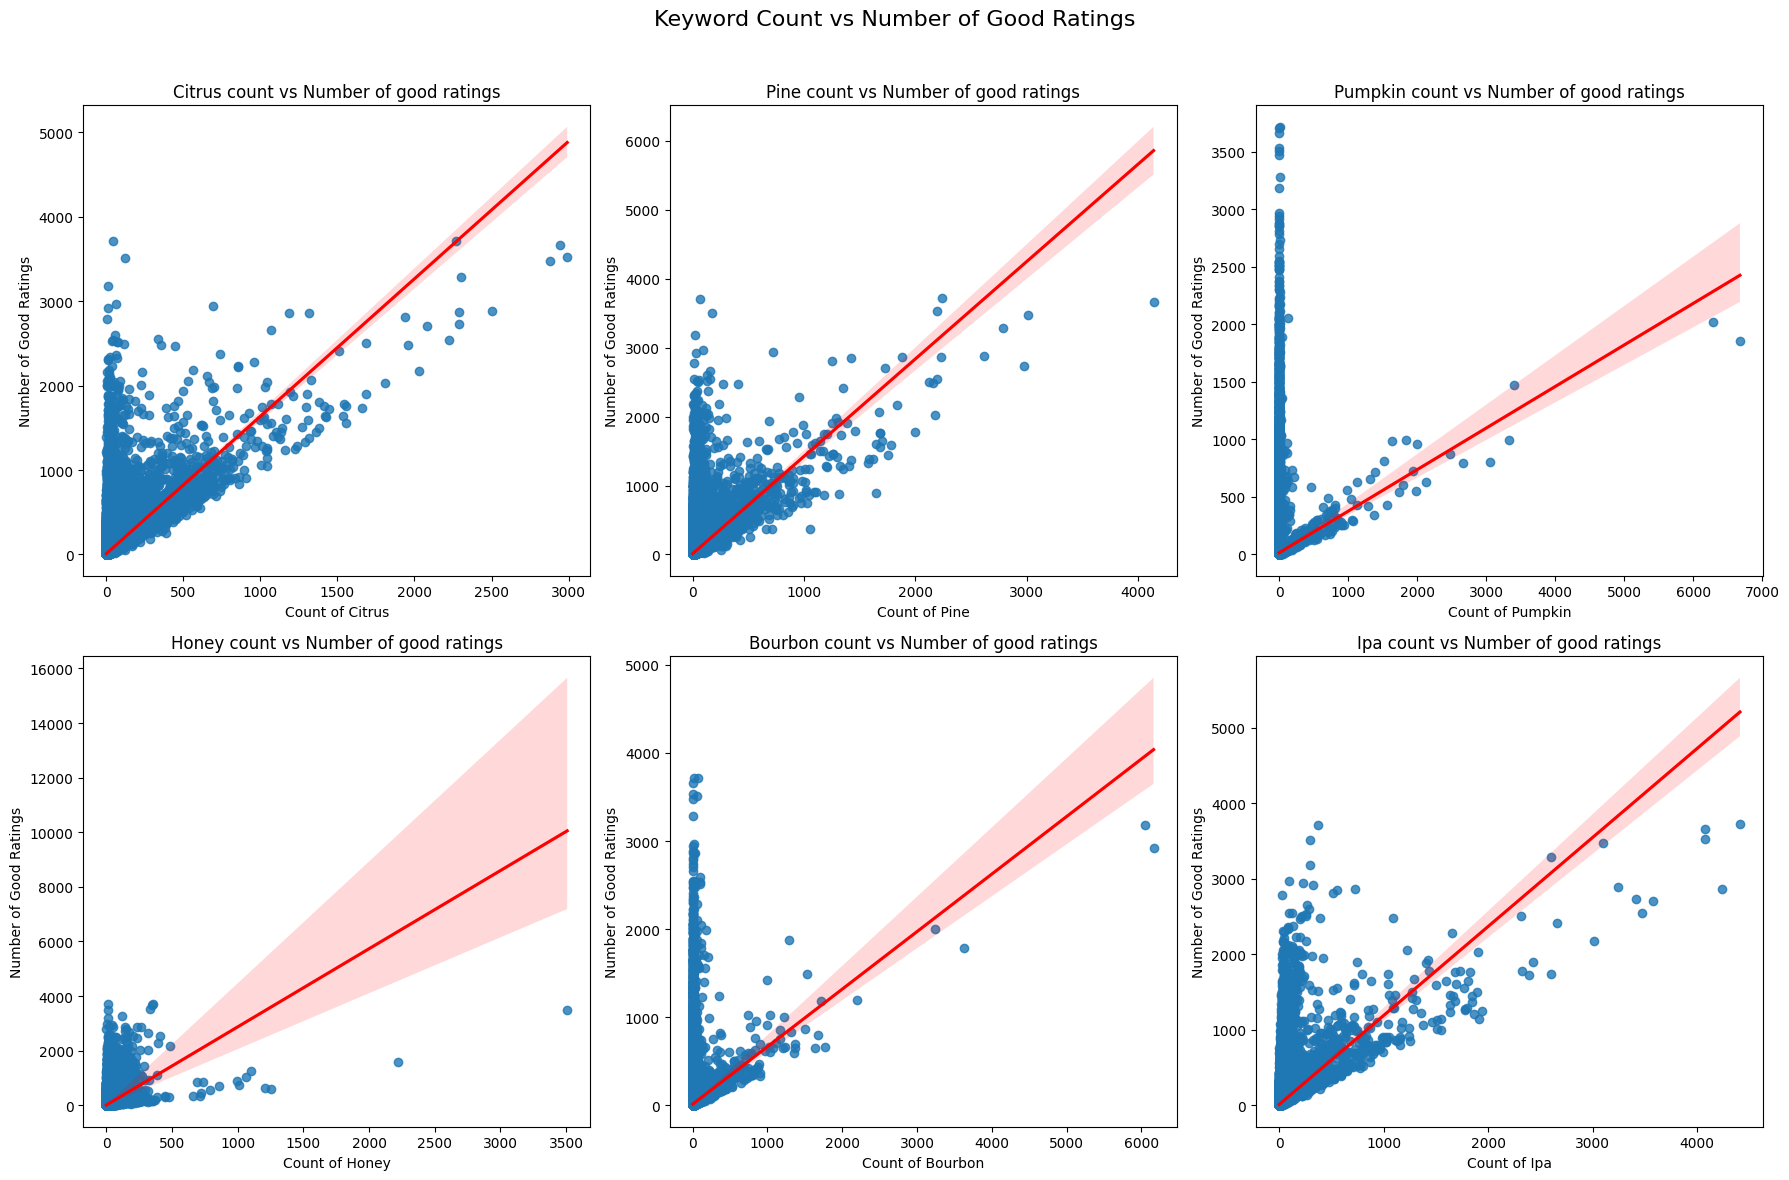

In [127]:
# separate the dataframe into two dataframes: one for BeerAdvocate and one for RateBeer
rating_df_ba = textual_ratings_df[textual_ratings_df['dataset'] == 'BeerAdvocate']
rating_df_rb = textual_ratings_df[textual_ratings_df['dataset'] == 'RateBeer']

# compute average of category
average_ba = rating_df_ba["rating"].mean()
average_rb = rating_df_rb["rating"].mean()

rating_df_ba['is_good'] = rating_df_ba["rating"] >= average_ba
rating_df_rb['is_good'] = rating_df_rb["rating"] >= average_rb

rating_df_ba['is_good'] = rating_df_ba['is_good'].astype(int)
rating_df_rb['is_good'] = rating_df_rb['is_good'].astype(int)

# concatenate the two dataframes
combined_rating = pd.concat([rating_df_ba, rating_df_rb], ignore_index=True)

# Find the best beer for the month based on average rating and review count
beer_df = combined_rating.groupby('new_id_beer').agg({"rating": ['mean', 'count'], 'is_good': 'count'}).reset_index()
beer_df.columns = ['new_id_beer', 'average_rating', 'total_review_count', 'good_review_count']

# group by new_beer_id the dataframe textual_ratings_df and sum the column "citrus" 
beer_top_keywords_df = textual_ratings_df.groupby('new_id_beer')[['pine', 'bourbon', 'ipa','honey', 'citrus', 'pumpkin']].sum()

# merge the two dataframes
beer_top_keywords_df = pd.merge(beer_top_keywords_df, beer_df, on='new_id_beer')

# Assuming your DataFrame is named beer_top_keywords_df
fig = plt.figure(figsize=(18, 12))
fig.suptitle('Keyword Count vs Number of Good Ratings', fontsize=16)

# List of keywords
keywords = ['citrus', 'pine', 'pumpkin', 'honey', 'bourbon', 'ipa']

# Create a 2x3 grid of subplots
gs = GridSpec(2, 3, figure=fig)

# Loop through each keyword and add a subplot
for i, keyword in enumerate(keywords, start=1):
    ax = fig.add_subplot(gs[(i - 1) // 3, (i - 1) % 3])

    # Create a scatter plot for the current keyword using sns.regplot
    sns.regplot(
        x=keyword,
        y='good_review_count',
        data=beer_top_keywords_df,
        ax=ax,
        line_kws={'color': 'red'}  # Change the color of the regression line
    )

    ax.set_title(f'{keyword.capitalize()} count vs Number of good ratings')
    ax.set_xlabel(f'Count of {keyword.capitalize()}')
    ax.set_ylabel('Number of Good Ratings')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

From the regression plots, we verify what the previous line plot showed us. Indeed, there is a possitive correlation between the frequency of the keywords in the textual rating and the number of good ratings of a beer. 

For the keywords *honey* and *pumpkin* or even *bourbon*, we observe high variations since their count is significant at certain period of the year, enlighting the idea of seasonality. 

In [129]:
for keyword in keywords:
    pearson_corr, pearson_p_value = pearsonr(beer_top_keywords_df[keyword], beer_top_keywords_df['good_review_count'])
    print(f"Pearson correlation coefficient between count of {keyword} keyword and number of good review: {pearson_corr}")
    print(f"P-value between count of {keyword} keyword and number of good review: {pearson_p_value}")
    print()

Pearson correlation coefficient between count of citrus keyword and number of good review: 0.6614794222890512
P-value between count of citrus keyword and number of good review: 0.0

Pearson correlation coefficient between count of pine keyword and number of good review: 0.553429802281102
P-value between count of pine keyword and number of good review: 0.0

Pearson correlation coefficient between count of pumpkin keyword and number of good review: 0.11167801970238109
P-value between count of pumpkin keyword and number of good review: 0.0

Pearson correlation coefficient between count of honey keyword and number of good review: 0.41434150820264004
P-value between count of honey keyword and number of good review: 0.0

Pearson correlation coefficient between count of bourbon keyword and number of good review: 0.1959961229654043
P-value between count of bourbon keyword and number of good review: 0.0

Pearson correlation coefficient between count of ipa keyword and number of good review: 0.5

EUREKA ! Pearson's test validates the positive correlation between the count of the keywords and the number of good ratings ! 

# Conclusion 

After an intense analysis of the different attributes, here is our recommendation for each month : 

| Month         | ABV    | Location | Aroma   | Taste   | Appearance | Palate  |
|-------        |------- |----------|---------|---------|------------|---------|
| January       | 8.0%   |    US    | Honey   | Sweet   |   Orange   |  Light  |
| February      | 8.0%   |    US    | Honey   |  Sweet  |  Orange    |  Light  |
| March         | 8.0%   |    US    | Citrus  |  Sweet  |    Amber   |  Medium |
| April         | 8.0%   |    US    | Bourbon | Stout   | Dark       | Thick   |
| May           | 8.0%   |    US    | Bourbon | Stout   | Dark       | Thick   |
| June          | 5.0%   |    US    | Citrus  | Fresh   | Caramel    | Medium  |
| July          | 5.0%   |    US    | Pine    | Bitter  | Orange     | Medium  |
| August        | 5.0%   |    US    | Pine    | IPA     | Orange     | Light   |
| September     | 6.0%   |    US    | Pumpkin | Spice   | Brown      | Light   |
| October       | 6.0%   |    US    | Pumpkin | Spice   | Brown      | Light   |
| November      | 8.0%   |    US    | IPA     | IPA     | Amber      | Medium  |
| December      | 8.0%   |    US    | IPA     | IPA     | Amber      | Medium  |

## 🍻 Happy Beer-Day and cheers ! 🍻